# Racing The Odds: Horse Racing from Then to Now 
A CS109 Project by George Bailey (Statistics '16), Morgan Breitmeyer (Statistics and Math '17), JPaul Meyer ('18), and William Stewart (Applied Math '17).  

## Overview and Motivation  
<i>Provide an overview of the project goals and the motivation for it. Consider that this will be read by people who did not see your project proposal. </i>

We seek to collect and examine horse racing data in order to 

### Betting on Horse Racing 101 
At its simplest, horse betting is looking at a lineup of up to 14 horses, and predicting which one(s) you think will place. We looked exclusively at the thoroughbred sphere of horse racing, as this is considered the most sophisticated form of the sport, meaning there is the most betting occuring and the most information about races.  

At the time of placing the bet, you have certain resources available to you:
<blockquote style="margin:0 0 0 40px;border:none;padding:0px">
</blockquote>
<ul style="list-style-type:disc">
  <li><b> Toteboard: </b> A large signposting of useful information, such as the win odds or payoffs for each horse, the total win pool, and the amount bet on any given horse.  The toteboard rounds down odds to the nearest dime, so the exact payoff may be slightly more or less depending on the exact value of the odds. &nbsp;</li>
  <li><b> Racetrack Program: </b> This has details on all the horses, trainers, owners, and jockeys in the races. You must pay \$3 for a copy. </li>
  <li><b> The Daily Racing Form: </b> This provides the historical racing data for each horse racing, as well as some articles and handicapping information by the staff responsible for this form.  You must pay \$4 for a copy.  </li>
  <li><b> Handicapping Tip Sheets: </b> The handicappers at each race track publish these daily to offer some selections of information and tips regarding the handicapping.  You must pay \$2 per copy. </li>
  <li><b> Public Handicapper Selections: </b> Depending on the town and situation, some town newspapers pay a handicapper to make selections which are then published. Cost paid depends on the local newspaper.  </li>
</ul>


<h1><font color="#38761d" size="3"> Calculating the Exact Odds: </font></h1>
To calculate the exact odds on a horse based on the information from the toteboard, do the following: 
<ol>
  <li> Cash paid out = (Total pool)*(1 - take) - (amount bet on given horse) </li>
  <li> Exact odds = (Cash paid out)/(amount bed on horse) </li>
  <li> Round for breakage. 
</li>
</ol>

<h1><font color="#38761d" size="3">Calculating Your Payoff:</font></h1>
The steps to do this are as follows: 
<ol>
  <li> Take 2 times the first number of win odds </li>
  <li> Divide this value by the second number </li>
  <li> Round the decimal down to the nearest dime.  </li>
  <li> Add \$2</li>
<li>To get your actual payoff, remove 14%-20% for the take. (Values below don't account for the take) &nbsp;</li>
</ol>
<div>Assuming a $2 bet, we can calculate some sample payoffs using a set of odds as examples<span style="background-color:transparent;line-height:1.5;font-size:10pt">&nbsp;</span><sup><a href="http://www.dummies.com/how-to/content/betting-on-horse-racing-for-dummies-cheat-sheet.html">1</a></sup><span style="background-color:transparent;line-height:1.5;font-size:10pt">:&nbsp;</span></div>
<img src="images/image_0.png" width="600px"/>

<br>
<h1><font color="#38761d" size="3">Types of Wager:</font></h1>
There is an intricate system of placing bets on horses for every race. &nbsp;Many different types of bets can be placed, as outlined below. &nbsp;It is useful to note that most tracks require a $2 minimum bet. 
<ul style="list-style-type:disc">
  <li><b> Win: </b> You place a bet on one horse and it must finish first to collect. <i>Average</i> chance of winning.&nbsp;</li>
  <li><b> Place: </b> You place a bet on one horse and it must finish first or second to collect.&nbsp;<i>Good</i>&nbsp;chance of winning.&nbsp;</li>
  <li><b> Show: </b> You place a bet on one horse and it must finish first, second, or third to collect.&nbsp;<i>Very good</i>&nbsp;chance of winning.&nbsp;</li>
  <li><b> Exacta: </b>You place a bet on two horses and they must finish first and second in order to collect. <i>Hard</i>&nbsp;to win.&nbsp;</li>
  <li><b> Exacta Box/Quinella: </b> You place a bet on two horses and they must finish first and second in either order to collect.&nbsp;<i>Average</i>&nbsp;chance of winning.&nbsp;</li>
  <li><b> Trifecta: </b> You place a bet on three horses and they must finish first, second, and third in exact order to collect.&nbsp;<i>Hard</i>&nbsp;to win.&nbsp;</li>
  <li><b> Trifecta Key: </b> You place a bet on at least three horses and choose one as the key horse.  The key horse must come in first, and any other horses you bet on can finish in second and third in any order to collect.&nbsp;</li>
  <li><b> Trifecta Box: </b> You place a bet on three horses and they must finish first, second, and third in any order to collect.</li>
  <li><b> Superfecta: </b> You place a bet on four horses and they must finish first, second, third, and fourth in exact order to collect.&nbsp;<i>Extremely hard</i>&nbsp;to win.&nbsp;</li>
  <li><b> Superfecta Box: </b> You place a bet on four horses and they must finish first, second, third, and fourth in any order to collect.&nbsp;</li>
  <li><b> Superfecta Key: </b>You place a bet on at least four horses and choose one as the key horse.  The key horse must come in first, and any other horses you bet on can finish in second, third, and fourth in any order to collect. </li>
<li><b> Daily Double: </b> You place a bet on two horses in separate but consecutive races, which must both finish first to collect. H<i>ard</i>&nbsp;to win.&nbsp;</li>
<li><b> Pick 3/4/6: </b> You place a bet on three (or four or six) horses from separate but consecutive races, who must each finish first their respective race consecutively for you to collect. <i>Very&nbsp;hard</i>&nbsp;to win,<i> extremely hard </i>to win, and <i>basically impossible </i>to win (respectively for 3, 4, and 6 horses).&nbsp;</li>
</ul>


<h1><font color="#38761d" size="3">Useful Terminology:</font></h1>
<ul style="list-style-type:disc">
  <li><b> Win odds: </b> Using the win odds, you can determine the amount of profit you will get if your bet is correct, referred to as the payoff.  An important distinction here is that this is not the total amount you will receive, just the profit.  For example, if you are correct for a win odds of 20-1, you will get a \$20 profit for each \$1 wagered. In the end, if you bet \$2, you will receive \$42 total. </li>
  <li><b> Breakage: </b> This is the downward rounding that occurs from actual win odds to the win odds displayed on the toteboard. &nbsp;In the US, breakage is in the downward direction to the nearest dime.&nbsp;</li>
  <li><b> Total (win) pool: </b> This is the total amount of money bet on all the horses to win for a given race. It is important to note that this is not the amount that will be given out to winners because the track deducts the <i> take </i>.  The take goes to funding the track's commission (for profit and expenses), taxes, and purse money for horsemen, and is between 14% and 20% (state dependent).  </li>
</ul>

## Related Work 
<i>Anything that inspired you, such as a paper, a web site, or something we discussed in class.</i>

We first conducted a throough study of horse racing and betting therein as follows to understand what we were working with. 

## Initial Questions 
<i>What questions are you trying to answer? How did these questions evolve over the course of the project? What new questions did you consider in the course of your analysis? - Data: Source, scraping method, cleanup, storage, etc. </i>

## Investigation 

In [4]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from bs4 import BeautifulSoup
import requests
import json
import time
import string
# from tqdm import *
import datetime
import math

## Scraping 
We began our adventure with an extensive amount of scraping.  We used many resources to access a large amount of data and hit many hiccups along the way.  For one, the data sources we were using were extremely varied and very disorganized.  

### Race History Scraping 
We obtained a significant amount of information on horse races across the US since 1998 from the website racingchannel.com.  The scraping process was complicated and long, but proved very useful.  

In [ ]:
# Gets main page's HTML
mainpagelink = 'http://racingchannel.com/results_archive.php'
mainpagehtml = requests.get(mainpagelink).text

We started at the mainpage of racingchannel.com (see below) to get a list of racetracks and racetrackcodes, and we then created a dict of the two, which was the basis for most of our subsequent scraping. This page on the website has hyperlinks to all the individual racetrack pages, so the first step of scraping was from here.  
<img src="images/image_1.png" width="600px"/>

In [ ]:
racetrackshtmllst = BeautifulSoup(mainpagehtml, 'html.parser').body.table.findAll('tr')[4].findAll('td')
tracks = []
trackcodes = []
trackdatalinks = []
for tracklst in racetrackshtmllst:
    tracklinks = tracklst.findAll('a')
    for link in tracklinks:
        trackdatalinks.append('http://racingchannel.com/'  + link.get('href').encode('ascii'))
        trackcodes.append(link.get('href')[10:13].encode('ascii'))
        tracks.append(link.text.encode('ascii'))
tracks[1] = 'Arlington Park'
trackcodedict = dict(zip(tracks, trackcodes))
tracklinkdict = dict(zip(tracks, trackdatalinks))
trackinfodf = pd.DataFrame(index=tracks)
trackinfodf['code'] = trackcodes
trackinfodf['link'] = trackdatalinks
trackinfodf.head()

Next, we then pulled the html of each individual track from the pages pulled above and beautifulSouped it.   The below code stores the cleaned html of all track info pages into a csv.  

In [ ]:
## WARNING: DO NOT RERUN THIS IF TEMPDATA ALREADY HAS TRACKINFO.CSV IN IT! ##

htmloftracks = []
for link in trackdatalinks:
    htmloftracks.append(BeautifulSoup(requests.get(link).text, 'html.parser'))
    print link
    time.sleep(5)

trackinfodf['track_html'] = htmloftracks
trackinfodf.head(10)

# Stores track codes and links in csv
trackinfodf.to_csv('tempdata/trackinfo.csv', index_label='name')

In [ ]:
# Loads trackinfodf from the csv in tempdata
try:
    del trackinfodf
except:
    pass
trackinfodf = pd.read_csv('tempdata/trackinfo.csv', index_col='name')
trackinfodf['track_html'] = trackinfodf['track_html'].apply(lambda h:BeautifulSoup(h, 'html.parser'))
trackinfodf.head(5)

Next, we stored all the years and months that races occured for each track.  From the above links, we are directed to a page of months and years, that each then direct to monthly calendars with races listed on the corresponding dates. Using this page, we scraped the needed years and months. A sample page for the track Aqueduct can be seen below. 

<img src="images/image_2.png" width="600px"/>

In [ ]:
# For each track rip the years and months that the track had races ran on it
tracksoups = trackinfodf['track_html']
yrmonthdicts_by_track = []
for soup in tracksoups:
    soup = soup.body.center.findAll('table')[-1].tr.findAll('td')
    years = []
    yrmonths_for_track = []
    for col in soup:
        year = col.text.encode('ascii')[:4]
        years.append(year)
        months = [elem.get('href').encode('ascii')[19:21] for elem in col.findAll('a')]
        yrmonths_for_track.append({year: months})

    yrmonthdicts_by_track.append(yrmonths_for_track)
biggie = dict(zip(trackcodes,yrmonthdicts_by_track))

Using the above obtained years and months, we next had to pull all the days from each calendar of races.  A sample month for October 1998 for the racetrack Aqueduct can be seen below.  
<img src="images/image_3.png" width="600px"/>

In [ ]:
# Scrapes all the days that the track was in operation for each month, year, and track combo
%time
trackday_lists = []
for track in sorted(biggie.keys()):
    for yeardict in biggie[track]:
        for month in yeardict.values()[0]:
            monthhtml = BeautifulSoup(requests.get('http://racingchannel.com/archives/{}/{}/{}/default.html'\
                                         .format(track,yeardict.keys()[0],month)).text, 'html.parser').body.center
            try:
                soup = monthhtml.findAll('table')[1]
            except:
                soup = monthhtml.findAll('table')[0]
            days = [daytag.get('href')[29:31].encode('ascii') for daytag in soup.findAll('a')]
            mo = daytag.get('href')[19:21].encode('ascii')
            yr = daytag.get('href')[14:18].encode('ascii')
            trk = daytag.get('href')[22:25].encode('ascii')
            for day in days:
                trackday_lists.append([trk, yr, mo, day]) 
            time.sleep(.00001)

    print track
    
print len(trackday_lists)

In [ ]:
# Stores a csv of the different days that races were run since 1998 at each track
# (scraped from the racingchannel.com website in order to make accessing the html easier)
trackdaylistdf = pd.DataFrame(trackday_lists)
trackdaylistdf.to_csv('tempdata/alldays_new.csv')

In [ ]:
# Reads back in the list of lists that contains all the days we need to request from racingchannel.com
bigdaydf = pd.read_csv('tempdata/alldays_new.csv')
bigdaydf = bigdaydf[bigdaydf.columns[-4:]]
bigdaydf.columns = ['track','year','month','day']
bigdaydf.head()

In [ ]:
# Ensure we have all the tracks
print tracks
bigdaydf.track.unique()

We made a decision to drop the international tracks for several reasons.  Firstly, we wanted to ensure the continuity of our data and there was spotty data from the international arenas.  Secondly, the weather data was hard to obtain for international locations, so it was dangerous.  Thirdly, considering the animal travel laws, it seemed difficult for international races to have significant impacts on our races as horses must be quarantined for extended periods of time whenever they cross international borders.  

In [ ]:
# Drop international tracks
bigdaydf = bigdaydf.set_index(bigdaydf['track'])
usadaydf = bigdaydf.drop(['GB1','ZA1','ZA2','AU1','AU2','FTE','HAS','NCF','WOB'])
print usadaydf.shape
print bigdaydf.shape
usadaydf.to_csv('tempdata/usadays_new.csv')

In [ ]:
# Read in the csv containing USA track days
usadaydf = pd.read_csv('tempdata/usadays_new.csv')
usadaydf.drop('track.1',axis=1, inplace=True)
print usadaydf.shape # this should be like 83000
print '\n'
usadaydf.head() #<--this is the one we want!!!!

This is where the most significant scraping began. Now that we had obtained the track names and corresponding race dates, we needed to scrape all the results for every date and every track. A sample results page for the Aqueduct track on October 28, 1998 can be seen below. 

<img src="images/image_4.png" width="600px"/>

This took a significant amount of time, so we included methods to track our progress along the way.  

In [ ]:
pretime = time.time()
superout = []
# Getting the raw HTML text from racingchannel to be later cleaned with BeautSoup
# The live 1-9 variables and the many if else statements that follow the main code all have to do with 
# setting and hitting checkpoints along the way
acc = 0
livee = True
live1 = True
live2 = True
live3 = True
live4 = True
live5 = True
live6 = True
live7 = True
live8 = True
live9 = True
for tup in usadaydf.itertuples():
    time.sleep(0.05)
    magiclink = 'https://www.racingchannel.com/archives/{}/{}/{:02}/{}{}{:02}{:02}.HTM'\
        .format(tup[1],tup[2],tup[3],tup[1],str(tup[2])[2:],tup[3],tup[4])
    htmlfrompage = requests.get(magiclink).text
    superout.append([tup[1],tup[2],tup[3],tup[4],htmlfrompage])
    acc += 1
    if acc > 100 and livee:
        livee = False
        print "Made it {}".format(acc)
    elif acc > 10000 and live1:
        live1 = False
        print "Made it {}".format(acc)
    elif acc > 20000 and live2:
        live2 = False
        print "Made it {}".format(acc)
    elif acc > 30000 and live3:
        live3 = False
        print "Made it {}".format(acc)
    elif acc > 40000 and live4:
        live4 = False
        print "Made it {}".format(acc)
    elif acc > 50000 and live5:
        live5 = False
        print "Made it {}".format(acc)
    elif acc > 60000 and live6:
        live6 = False
        print "Made it {}".format(acc)
    elif acc > 70000 and live7:
        live7 = False
        print "Made it {}".format(acc)
    elif acc > 80000 and live8:
        live8 = False
        print "Made it {}".format(acc)
        print "Home stretch!!!"  
    

superdf = pd.DataFrame(superout)
superdf.to_csv('tempdata/superdf.csv')

print time.time()-pretime, "seconds"

Our data obtained above was MASSIVE, so we had a very hard time reading the csv we created back into our iPython notebook. We constantly had memory errors when trying to read in the csv in one chunk, so used the chunksize option in pd.read_csv to overcome this problem.

In [ ]:
# adapted from http://stackoverflow.com/questions/17557074/memory-error-when-using-pandas-read-csv
csv_chunks = pd.read_csv('~/Desktop/superdf.csv', sep = ',', chunksize = 5000)
superdf = pd.concat(chunk for chunk in csv_chunks)
superdf = superdf[superdf.columns[-5:]]
superdf.columns = ['track','year','month','day','html']

In [ ]:
## When we saved the csv of a list, it saves it as a string.  This function then converts that 
## string back into a list. This turned out to be less useful than we thought when we wrote it.  
def stringtolist(string):
    elems = []
    curr = ''
    acc = 0
    for char in list(string):
        if char in '[':
            pass
        elif (char == ',' and list(string)[acc-1] in '>') or (char == ']'):
            elems.append(curr)
            curr = ''
        else:
            curr += char
        acc += 1
    return elems
a = '[<new>asdf</new>,<yeet>asdfaghfds,FF<yeet>,<FF>masdfasdf</FF>]'
print stringtolist(a)

In [ ]:
## We used a class object to make the scraping easier.  

class RaceDataSet(object):
    
    def __init__(self, num, datedata):
        self.num = num
        self.datedata = datedata
        self.first = None
        self.second = None
        self.third = None
        self.firstnum = None
        self.secondnum = None
        self.thirdnum = None
        self.win = None
        self.place1 = None
        self.place2 = None
        self.show1 = None
        self.show2 = None
        self.show3 = None
        
    def __str__(self):
        return "{} : {}.....{}.{}...{}.{}...{}.{}\n\t{}...{}.{}.....{}.{}.{}\n".format(self.datedata,self.num,self.firstnum,\
                    self.first,self.secondnum,self.second,self.thirdnum,self.third,self.win,self.place1,\
                    self.place2,self.show1,self.show2,self.show3)
    
    def to_list(self):
        return [self.datedata[0],self.datedata[1],self.datedata[2],self.datedata[3],self.num,self.firstnum,\
                    self.first,self.secondnum,self.second,self.thirdnum,self.third,self.win,self.place1,\
                    self.place2,self.show1,self.show2,self.show3]

We next created an important function that does a significant portion of the parsing of the html.  Firstly, it uses BeautifulSoup on the html, and then it goes through all of it, takes the row elements of each race, and puts the data into a dataframe.  This function is designed to take a row from superdf (the csv of the raw html), and then parse the html of only that page. Again, memory considerations forced us to approach the problem this way, as we could not hold very much of this data in memory at a time. Going row by row solved this problem.

In [ ]:
def extract(row):
    tags = None
    date = None
    nobolds = []
    if isinstance(row, pd.Series):
        tags = BeautifulSoup(row['html'], 'html.parser').html.body.findAll('table')
        date = [row['track'],row['year'],row['month'],row['day']]
    elif isinstance(row, tuple):
        if str(row[5]) == 'nan':
            return []
        tags = BeautifulSoup(row[5], 'html.parser').html.body.findAll('table')
        date = [row[1],row[2],row[3],row[4]]
    out = []
    for table in tags:
        bail = False
        if table.findAll('tr') == []:
            continue
        elif table.tr.findAll('b') == []:
            continue
        elif table.tr.td.b == None:
            nobolds.append((table.tr.td,date)) 
        elif 'race' in string.lower(table.tr.td.b.get_text().encode('ascii')):
            trows = table.findAll('tr')
            if len(trows) >= 4:
                row1 = trows[0].findAll('td')
                row2 = trows[1].findAll('td')
                row3 = trows[2].findAll('td')
                row4 = trows[3].findAll('td')
                if len(row2) > 0 and len(row3) > 0 and len(row4) > 0:
                    for elem in [row2[0].get_text().encode('ascii'),row3[0].get_text().encode('ascii'),\
                        row4[0].get_text().encode('ascii')]:
                        if '$2 D/Double' in str(elem):
                            bail = True
                    if not bail:
                        if not (len(row2) < 6 or len(row3) < 6 or len(row4) < 6):
                            racenum = row1[1].get_text().encode('ascii')
                            obj = RaceDataSet(racenum, date)
                            obj.firstnum = row2[1].get_text().encode('ascii')
                            obj.first = row2[2].get_text().encode('ascii')
                            obj.secondnum = row3[1].get_text().encode('ascii')
                            obj.second = row3[2].get_text().encode('ascii')
                            obj.thirdnum = row4[1].get_text().encode('ascii')
                            obj.third = row4[2].get_text().encode('ascii')
                            obj.win = row2[3].get_text().encode('ascii')
                            obj.place1 = row2[4].get_text().encode('ascii')
                            obj.place2 = row3[4].get_text().encode('ascii')
                            obj.show1 = row2[5].get_text().encode('ascii')
                            obj.show2 = row3[5].get_text().encode('ascii')
                            obj.show3 = row4[5].get_text().encode('ascii')

                            out.append(obj.to_list())
    return out

We then created a cleaned dataframe by running a for loop using the above function, going row by row through superdf. We focused on getting win, place, show payoffs for each horse.

In [ ]:
cleandf = []
count = 0
for tup in tqdm(superdf.itertuples()):
    count += 1
    #controls the scale of the problem during testing
    if count < 0:
        continue
    elif count > 1000000:
        break
    cleandf += extract(tup)
cleandf = pd.DataFrame(cleandf, columns=['track','year','month','day','racenum','firstnum','first','secondnum',\
                                         'second','thirdnum','third','win','place1','place2','show1','show2','show3'])
cleandf.to_csv('tempdata/cleandf.csv', columns=['track','year','month','day','racenum','firstnum','first','secondnum',\
                                         'second','thirdnum','third','win','place1','place2','show1','show2','show3'])
cleandf.head()

In [ ]:
cleandf = pd.read_csv('tempdata/cleandf.csv')
cleandf = cleandf[cleandf.columns[-17:]]
cleandf.head()

Our cleaned race history data is in the csv called cleandf.  This is what we will use when we run our analysis and investigation later on.  

### Weather Scraping 
With the race data in hand, we turned to obtaining the weather data for all relavent dates.  We were able to access the Wunderground weather API thanks to special permission from the Weather Channel.  Using this, we obtained weather conditions for every date that we had race information available for the corresponding zip codes.  

An example of how to use the API for a set date and zip code: 

In [ ]:
date = '20141225'
zip_code = '11420'
wunderground_url = 'http://api.wunderground.com/api/4a26cfc369eb7841/history_{}/q/{}.json'.format(date, zip_code)
examp = json.loads(requests.get(wunderground_url).text)

We decided on a list of weather conditions that would be most likely to effect the racetracks on any given day.  Given Wunderground had hundreds of weather parameters, we had to limit the scope of our scrape to avoid overfitting.  Many of the parameters given were duplicates, as each parameter was available in metric or imperial units, as well as max, min, and average. For the parameters we chose, we used metric units and average amounts if available and applicable.   

In [3]:
# weather metrics we want
weather_data = ['fog','hail','maxhumidity','meandewptm','meanpressurem','meantempm','meanvism',
                'meanwdird', 'meanwindspdm', 'precipm', 'rain', 'snow', 'snowdepthm','snowfallm', 'thunder',
                'minhumidity']

In [4]:
# function to format data returned from wunderground api to have only the metrics we want
def output_dict(in_dict):
    temp = [(elem,in_dict[elem]) for elem in in_dict.keys() if elem in weather_data]
    return dict(temp)

In [7]:
output_dict(examp['history']['dailysummary'][0])

{u'fog': u'1',
 u'hail': u'0',
 u'maxhumidity': u'96',
 u'meandewptm': u'3',
 u'meanpressurem': u'1008',
 u'meantempm': u'10',
 u'meanvism': u'13',
 u'meanwdird': u'261',
 u'meanwindspdm': u'27',
 u'minhumidity': u'35',
 u'precipm': u'1.52',
 u'rain': u'1',
 u'snow': u'0',
 u'snowdepthm': u'0.00',
 u'snowfallm': u'0.00',
 u'thunder': u'0'}

In [8]:
# read in the csv of dates we want to get weather data for from previous scraping 
datesdf = pd.read_csv("tempdata/usadays.csv")
datesdf.drop('track.1',axis=1, inplace=True)
datesdf.head()

,track,year,month,day
0,AQU,1998,10,28
1,AQU,1998,10,29
2,AQU,1998,10,30
3,AQU,1998,10,31
4,AQU,1998,11,1


In [ ]:
# convert date components to strings and add a 0 before single digit month/days
datesdf[['year', 'month', 'day']] = datesdf[['year', 'month', 'day']].astype(str)
for line in datesdf.index:
    if len(datesdf.loc[line]['month']) == 1:
        datesdf.loc[line]['month'] = '0' + datesdf.loc[line]['month']
    if len(datesdf.loc[line]['day']) == 1:
        datesdf.loc[line]['day'] = '0' + datesdf.loc[line]['day']

# dictionary keyed by track to store corresponding date strings
dates_dict = {}

# stores all dates on which races occurred for a given track identifier
for track in datesdf.track.unique():
    datestring = []
    for row in datesdf.index:
        if datesdf.iloc[row]['track'] == track:
            datestring.append(str(datesdf.iloc[row]['year']) + str(datesdf.iloc[row]['month']) + 
                              str(datesdf.iloc[row]['day']))
    dates_dict[track] = datestring 
    
# zipcodes for all U.S. tracks, looked up manually and arranged into alphabetical order (according to 
# track abbreviations)
zips1 = ['11420', '60005','94403', '11003', '43123', '33056', '55379','40208', '23124', '25438', '70668', 
         '92014', '19804', '42420', '98001', '70570', '70119', '14425', '91768', '62234', '49415', '94710', 
         '33009', '60804', '46013', '90305', '46176', '40510', '42134', '20725', '71111', '75050', '90720', 
         '07073', '07757', '26047', '71901', '85023', '17028', '19020', '21215', '50009', '73111', '78154', 
         '45230', '77064', '91007', '12866', '60804', '02128', '33626', '44128', '21093', '41042']

# obtained by manual lookup, arranged in alphabetical order (according to 3 letter track identifier)
locs = datesdf.track.unique()

# dictionary mapping track identifiers to zipcodes
zips_dict1 = dict(zip(locs, zips1))

This is the main scraping function for the weather data.  We went by zip code and date and pulled the entire html for each location and time.  

In [ ]:
# queries wunderground API for every track-date combination
# stores results in dictionary keyed by (track id, date) tuple
%%time
weather_dict = {}
except_list = []
for key in dates_dict.keys():
    for fdate in dates_dict[key]:
        wunderground_url = 'http://api.wunderground.com/api/4a26cfc369eb7841/history_{}/q/{}.json'.format(fdate, zips_dict1[key])
        try:
            temp = json.loads(requests.get(wunderground_url).text)['history']['dailysummary'][0]
            weather_dict[(key, fdate)] = output_dict(temp)
        except:
            except_list.append((key,fdate))

In [ ]:
## WARNING: do NOT run this line again ## 
# weather_df.to_csv('tempdata/weather.csv')

We were able to save our data into a csv by running all the scraping and cleaning commands above, which gave us the following dataframe.  

In [4]:
weather_df = pd.read_csv("tempdata/weather.csv", index_col=0)
weather_df.head()

,track,date,fog,hail,maxhumidity,meandewptm,meanpressurem,meantempm,meanvism,meanwdird,meanwindspdm,minhumidity,precipm,rain,snow,snowdepthm,snowfallm,thunder
0,REM,2004-09-25,0,0,94,12,1021,21,11,13,8,23,0.00,0,0,NaN,0,0
1,DPK,2013-06-12,0,0,87,17,1010,24,16,299,14,47,0.00,0,0,0,0,0
2,FMT,2013-06-01,0,0,94,17,1009,22,15,182,10,61,12.95,1,0,NaN,0,1
3,PAR,2005-02-25,0,0,80,6,1012,13,16,30,8,38,0.00,0,0,NaN,0,0
4,BEU,2013-05-04,0,0,66,6,1017,17,16,101,16,40,0.00,0,0,NaN,0,0


### Cleaning the Weather Data  

In [ ]:
# converts all cells in date column to datetime objects
weather_df.date = weather_df.date.apply(lambda x: datetime.datetime(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))

In [ ]:
# handles non-numberic entries in numberic columns
weather_df.precipm.loc[weather_df.precipm =="T"] = np.nan
weather_df.snowdepthm.loc[weather_df.snowdepthm == "T"] = np.nan
weather_df.snowfallm.loc[weather_df.snowfallm == "T"] = np.nan

# casts all weather metrics as floats
for col in weather_df.iloc[:,2:]:
    weather_df[col] = weather_df[col].astype(float)
weather_df.head()

In [ ]:
weather_df.to_csv('tempdata/weather.csv')

### Test Data Scraping
We obtained the full race results for the three test races of interest: The Kentucky Derby, The Preakness Downs, and the Belmont Stakes.  We obtained all this data from many Wikipedia pages, which proved very frustrating, as they were atrociously messy.  We ran into many corner cases, so that took a lot of investigation to account for.  

In [140]:
## we create any empty dictionary which will hold all the html from the wikipedia pages 
pages = {}

## we create a dictionary of track years linked to the track names for the races 
## Belmont Stakes only had data from 2006 onward, while for the other two, we got data from 
## 1998 onward as that is how far our training data goes 
years1 = [str(i) for i in range(1998,2016)]
years2 = [str(i) for i in range(2006,2016)]
track_year_dict = {"_Kentucky_Derby": years1, "_Preakness_Stakes": years1, "_Belmont_Stakes": years2}

## obtaining all the html pages and putting them into our dictionary pages 
for key in track_year_dict.keys():
    for year in track_year_dict[key]:
        pages[year+key] = requests.get("https://en.wikipedia.org/wiki/{}".format(year+key)).text
        time.sleep(0.1)
        
# function to parse scraping output
# returns 2 data frames, one for payouts and one for results for a given race in a given year
def parser(key, page_dict):
    soup = BeautifulSoup(page_dict[key], "html.parser")
    tables = soup.find_all("table", attrs={"class": "wikitable"})
    
    if len(tables[0].find_all("tr")) <= 5:
        table1 = tables[0].find_all("tr")
        table2 = tables[1].find_all("tr")
    else:
        table1 = tables[1].find_all("tr")
        table2 = tables[0].find_all("tr")
    
    t1headers = [elem.get_text() for elem in table1[0].find_all("th")]
    t2headers = [elem.get_text() for elem in table2[0].find_all("th")]
    if (key == "2005_Kentucky_Derby"):
        t2headers.append("Time")
        t2headers[t2headers.index("Jockey")] = "Horse"
    
    t1 = []
    t2 = []
    for row1 in table1[1:]:
        r1_data = [cell.get_text() for cell in row1.find_all("td")]
        t1.append(r1_data)
    for row2 in table2[1:]:
        # handles cases where cells in horse column all have header tags
        if row2.find("th"):
            r2_data = [cell.get_text() for cell in row2.find_all("td")]
            r2_data.insert(2, row2.find("th").get_text())
            t2.append(r2_data)
        else:
            r2_data = [cell.get_text() for cell in row2.find_all("td")]
            t2.append(r2_data)       
    try:
        payout = pd.DataFrame(t1, columns=t1headers)
        results = pd.DataFrame(t2, columns=t2headers)
    except Exception,e:
        # handles 2015 Kentucky Derby results table, which doesn't have a header row
        if key == "2015_Kentucky_Derby":
            t1headers = [elem.get_text() for elem in table1[0].find_all("td")]
            payout = pd.DataFrame(t1, columns=t1headers)
            results = pd.DataFrame(t2, columns=t2headers)
        else:
            print str(e)
  
    return (payout, results)

# dictionary of data frames keyed by track-year string
# values are tuples of data frames returned by parser
bigdict = {key:parser(key, pages) for key in pages.keys()}

# constructs single payouts data frame by concatenating all payout data frames contained in bigdict
payouts_df = pd.DataFrame(columns=["Post", "Horse", "Win", "Place", "Show", "Track", "Year"])
for track in track_year_dict.keys():
    for year in track_year_dict[track]:
        access = year+track
        bigdict[access][0].columns = ["Post", "Horse", "Win", "Place", "Show"]
        bigdict[access][0]["Track"] = track
        bigdict[access][0]["Year"] = year
        payouts_df = pd.concat([payouts_df, bigdict[access][0]], ignore_index = True)

In [136]:
payouts_df = pd.read_csv("tempdata/payouts.csv", index_col=0)
payouts_df.head()

,Post,Horse,Win,Place,Show,Track,Year
0,11,Real Quiet,$7.00,$3.60,$3.00,_Preakness_Stakes,1998
1,10,Victory Gallop,-,$3.20,$2.80,_Preakness_Stakes,1998
2,3,Classic Cat,-,-,$4.80,_Preakness_Stakes,1998
3,6,Charismatic,$18.80,$7.60,$5.80,_Preakness_Stakes,1999
4,5,Menifee,-,$3.60,$3.20,_Preakness_Stakes,1999


In [137]:
# function to clean "Win", "Place", and "Show" columns above
# converts strings to ints
def dollar_clean(inpt):
    try:
        if "$" in inpt:
            a = inpt.split("$")
            a = a[1]
            if " " in a:
                b = a.split(" ")
                c = b[1]
                return float(c)
            else:
                return float(a)
        else:
            return float(inpt)
    except:
        return inpt
    
# function to handle non-numeric entries in "Post" column above
def clean_post(inpt):
    try:
        return int(inpt)
    except:
        return 0

In [196]:
# clean payouts df
payouts_df.replace("-", 0, inplace=True)
payouts_df.replace(u"\u2013", 0, inplace=True)
payouts_df.replace("", 0, inplace=True)
payouts_df.Post = payouts_df.Post.apply(clean_post)
payouts_df.Win = payouts_df.Win.apply(dollar_clean)
payouts_df.Place = payouts_df.Place.apply(dollar_clean)
payouts_df.Show = payouts_df.Show.apply(dollar_clean)
payouts_df.head()

,Post,Horse,Win,Place,Show,Track,Year
0,11,Real Quiet,7.0,3.6,3.0,_Preakness_Stakes,1998
1,10,Victory Gallop,0.0,3.2,2.8,_Preakness_Stakes,1998
2,3,Classic Cat,0.0,0.0,4.8,_Preakness_Stakes,1998
3,6,Charismatic,18.8,7.6,5.8,_Preakness_Stakes,1999
4,5,Menifee,0.0,3.6,3.2,_Preakness_Stakes,1999


In [197]:
def any_in(my_list, comp_list):
    ret_list = []
    for item in my_list:
        if item in comp_list:
            ret_list.append(item)
    return ret_list

def dropper(df, my_list):
    drops = any_in(my_list, df.columns)
    df.drop(drops, axis=1, inplace=True)
    return df

def renamer(df, old_names, new_name):
    if any_in(old_names, df.columns):
        rename = any_in(old_names, df.columns)[0]
        newcolnms = list(df.columns)
        index = newcolnms.index(rename)
        newcolnms[index] = new_name
        df.columns = newcolnms
    
    
drop_list = ["Trainer", "Jockey", "Owner", "Lengths\nBehind", "Time / behind", "Time/\nBehind", 
             "Trainer\n\n", "Points[7]", "Points", "Previous Race", "Time"]
Horse = ["Horse name"]
Finish = ["Finish\nPosition", "Finish[2]", "Results", "Finished", "Position", "Finish\nposition", "Finish"]
Post = ["Post\nPosition", "Number", "Program\nNumber", "Post\nposition", "Pgm", "Post"]
Stakes = ["Stake", "Purse\nEarnings", "Stakes"]
MOdds = ["Morning Line\nOdds", "Morning\nline\nodds", "Opening odds (to 1)", "Opening Odds", "Morning\nodds[3]",
        "Morning Line Odds", "Morning Line\nodds", "Morning\nOdds[3]", "Opening\nOdds"]
POdds = ["Final\nodds[1]", "Post Time\nOdds", "Final odds[4]", "Post Time\nodds", "Final Odds", "Final Odds[2]",
        "Final odds", "Final odds\nto $1[1]", "Odds"]

for k in bigdict.keys():
    dropper(bigdict[k][1], drop_list)
    renamer(bigdict[k][1], Horse, "Horse")
    renamer(bigdict[k][1], Finish, "Finish")
    renamer(bigdict[k][1], Post, "Post")
    renamer(bigdict[k][1], Stakes, "Stakes")
    renamer(bigdict[k][1], MOdds, "Morning Line Odds")
    renamer(bigdict[k][1], POdds, "Post Time Odds")

In [198]:
results_df = pd.DataFrame(columns=["Track", "Year", "Finish", "Post", "Horse", "Morning Line Odds", "Post Time Odds", "Stakes"])
for track in track_year_dict.keys():
    for year in track_year_dict[track]:
        access = year+track
        bigdict[access][1]['Track'] = track
        bigdict[access][1]['Year'] = year
        results_df = pd.concat([results_df, bigdict[access][1]], ignore_index = True)

In [143]:
for c in ["Morning Line Odds", "Post Time Odds"]:
    for i in results_df.loc[(results_df.Track == "_Belmont_Stakes")&(results_df.Year == "2015")].index:
        results_df[c].iloc[i] = results_df[c].iloc[i][20:]
results_df.head()

,Finish,Horse,Morning Line Odds,Post,Post Time Odds,Stakes,Track,Year
0,1st,Real Quiet,NaN,11,2.50-1,"$650,000",_Preakness_Stakes,1998
1,2nd,Victory Gallop,NaN,10,2.00-1\nfavorite,"$200,000",_Preakness_Stakes,1998
2,3rd,Classic Cat,NaN,3,12.30-1,"$100,000",_Preakness_Stakes,1998
3,4th,Hot Wells,NaN,7,25.20-1,"$50,000",_Preakness_Stakes,1998
4,5th,Black Cash,NaN,2,7.10-1,,_Preakness_Stakes,1998


In [144]:
# http://stackoverflow.com/questions/944700/how-to-check-for-nan-in-python
def isNaN(num):
    return num != num

def make_odds(item):
    try:
        if (item == "scr") or (item == "Scr") or (item == "SCR") or (item == "DNR"):
            return 0
        elif " !" in item: 
            return float(item[0:4])
        
        q = item.split(u'\u2660')
        if len(q) > 1:
            q = q[1]
        else:
            q = q[0]
        
        y = q.split("\n")
        if "-" in y[0]: 
            x = y[0].split("-")
        elif u"\u2014" in y[0]:
            x = y[0].split(u"\u2014")
        if len(x) > 1:
            return float(x[0])/float(x[1])
        else:
            
            return float(a[0])
    except Exception, e:
        return item

def clean_finish(inpt):
    if not isinstance(inpt, int):
        if len(inpt) > 2 and inpt[:-2].isdigit():
            return int(inpt[:-2])
        elif inpt.isdigit():
            return int(inpt)
        else:
            return 0
    else:
        return inpt

In [145]:
smallresults_df = results_df[["Finish", "Post", "Horse", "Morning Line Odds", "Post Time Odds", "Track", "Year"]]
smallresults_df["Odds"] = np.nan
for num in smallresults_df.index:
    if not isNaN(smallresults_df["Morning Line Odds"].iloc[num]):
        smallresults_df["Odds"].iloc[num] = smallresults_df["Morning Line Odds"].iloc[num]
    else:
        smallresults_df["Odds"].iloc[num] = smallresults_df["Post Time Odds"].iloc[num]
smallresults_df.drop(["Morning Line Odds", "Post Time Odds"], axis=1, inplace=True)
smallresults_df["Odds2"] = smallresults_df.Odds.apply(make_odds)
smallresults_df.head()

/Users/morganfbreitmeyer/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Finish,Post,Horse,Track,Year,Odds,Odds2
0,1st,11,Real Quiet,_Preakness_Stakes,1998,2.50-1,2.5
1,2nd,10,Victory Gallop,_Preakness_Stakes,1998,2.00-1\nfavorite,2
2,3rd,3,Classic Cat,_Preakness_Stakes,1998,12.30-1,12.3
3,4th,7,Hot Wells,_Preakness_Stakes,1998,25.20-1,25.2
4,5th,2,Black Cash,_Preakness_Stakes,1998,7.10-1,7.1


In [146]:
#smallresults_df.to_csv('tempdata/smallresults.csv', encoding="utf8")

In [199]:
smallresults_clean = pd.read_csv("tempdata/109_OddsDF.csv", index_col=0)
smallresults_clean["Odds"] = smallresults_clean["Odds2"]
smallresults_clean.drop("Odds2", axis=1, inplace=True)
smallresults_clean = smallresults_clean.reset_index()
smallresults_clean.drop("index", axis=1, inplace=True)
smallresults_clean.Horse.iloc[190] = smallresults_clean.Horse.iloc[190][:-3]
smallresults_clean.Post.iloc[528:540] = [8,9,2,11,6,3,1,4,12,5,7,10]
smallresults_clean.Finish.iloc[557:562] = [1,2,3,4,5]
smallresults_clean.Finish.iloc[615:617] = [4,4]
smallresults_clean.Finish = smallresults_clean.Finish.apply(clean_finish)
smallresults_clean.Post = smallresults_clean.Post.apply(clean_post)
smallresults_clean.Year = smallresults_clean.Year.astype(str)

In [200]:
smallresults_clean.to_csv("tempdata/smallresults_clean.csv")

In [201]:
result_testdf = pd.merge(payouts_df, smallresults_clean, how="right", on=["Track", "Year", "Horse", "Post"])

In [203]:
result_testdf.head()

,Post,Horse,Win,Place,Show,Track,Year,Finish,Odds
0,11,Real Quiet,7.0,3.6,3.0,_Preakness_Stakes,1998,1,2.5
1,10,Victory Gallop,0.0,3.2,2.8,_Preakness_Stakes,1998,2,2.0
2,3,Classic Cat,0.0,0.0,4.8,_Preakness_Stakes,1998,3,12.3
3,6,Charismatic,18.8,7.6,5.8,_Preakness_Stakes,1999,1,8.4
4,5,Menifee,0.0,3.6,3.2,_Preakness_Stakes,1999,2,2.0


In [204]:
result_testdf.to_csv("tempdata/result_testdf.csv")

### Cleaning up above data to make it the format we want 

In [45]:
cleandf = pd.read_csv("tempdata/cleandf.csv", index_col=0); 
cleandf.head() 

,track,year,month,day,racenum,firstnum,first,secondnum,second,thirdnum,third,win,place1,place2,show1,show2,show3
0,AQU,1998,10,28,1,3,CURVY IMAGE,6,DYNABILITY,2,ALYDAR'S JET,6.3,3.8,5.9,3.0,4.3,5.0
1,AQU,1998,10,28,2,3,MILLIONDOLLARSMILE,8,THIS BLISS,2,DOUBLE COVERAGE,14.0,4.8,3.4,3.1,2.6,3.0
2,AQU,1998,10,28,3,6,ROOK,2,ALEXTHETHIRD,8,LITTLE GHAZI,6.5,3.4,3.5,2.4,2.2,2.2
3,AQU,1998,10,28,4,2,WAPO,4,AUNT EVIE,8,WINTER BID,6.2,5.1,67.0,2.8,11.6,2.1
4,AQU,1998,10,28,5,8,FUNNY TOY (ARG),6,KANE KATI,1,MT. ARROW,16.0,7.7,6.3,3.5,3.9,3.1


In [46]:
cleandf["date"] = [datetime.datetime(cleandf.year.iloc[row],cleandf.month.iloc[row],cleandf.day.iloc[row]) for row in cleandf.index]; 
cleandf.drop(["year", "month", "day"], inplace = True, axis =1 ); 

subdf1 = cleandf[["track", "racenum", "date", "firstnum", "first", "win", "place1", "place2", "show1", "show2", "show3"]]; 
subdf2 = cleandf[["track", "racenum", "date", "secondnum", "second", "win", "place1", "place2", "show1", "show2", "show3"]]; 
subdf3 = cleandf[["track", "racenum", "date", "thirdnum", "third", "win", "place1", "place2", "show1", "show2", "show3"]]; 
subdf1["fin_pos"] = 1; 
subdf2["fin_pos"] = 2; 
subdf3["fin_pos"] = 3; 

subdf1.rename(columns={'firstnum': 'post', 'first': 'name'}, inplace=True); 
subdf2.rename(columns={'secondnum': 'post', 'second': 'name'}, inplace=True); 
subdf3.rename(columns={'thirdnum': 'post', 'third': 'name'}, inplace=True); 

subdf3.win = 0; 
subdf3["place"] = 0;  
subdf3["show"] = subdf3.show3; 

subdf2.win = 0; 
subdf2["place"] = subdf2.place2;  
subdf2["show"] = subdf2.show2; 

subdf1["place"] = subdf1.place1;  
subdf1["show"] = subdf1.show1;  

subdf1.drop(["place1", "place2", "show1", "show2", "show3"], inplace = True, axis =1 ); 
subdf2.drop(["place1", "place2", "show1", "show2", "show3"], inplace = True, axis =1 ); 
subdf3.drop(["place1", "place2", "show1", "show2", "show3"], inplace = True, axis =1 ); 

frames = [subdf1, subdf2, subdf3]; 
final_race_df = pd.concat(frames); 

/Users/morganfbreitmeyer/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/morganfbreitmeyer/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/morganfbreitmeyer/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in th

In [47]:
final_race_df.head(25)

,track,racenum,date,post,name,win,fin_pos,place,show
0,AQU,1,1998-10-28,3,CURVY IMAGE,6.3,1,3.8,3.0
1,AQU,2,1998-10-28,3,MILLIONDOLLARSMILE,14.0,1,4.8,3.1
2,AQU,3,1998-10-28,6,ROOK,6.5,1,3.4,2.4
3,AQU,4,1998-10-28,2,WAPO,6.2,1,5.1,2.8
4,AQU,5,1998-10-28,8,FUNNY TOY (ARG),16.0,1,7.7,3.5
5,AQU,6,1998-10-28,6,RUBY RUBLES,11.4,1,5.6,4.8
6,AQU,7,1998-10-28,5,EXCHANGE PLACE,9.2,1,4.4,2.9
7,AQU,8,1998-10-28,2,EARLY WARNING,16.4,1,6.6,5.3
8,AQU,9,1998-10-28,4,JET BLACK,20.4,1,11.0,6.4
9,AQU,1,1998-10-29,1a,CRITICS ACCLAIM,3.6,1,2.2,2.1


In [154]:
weather_df = pd.read_csv("tempdata/weather.csv", index_col=0);
weather_df.date = pd.to_datetime(weather_df.date)
weather_df.head()

,track,date,fog,hail,maxhumidity,meandewptm,meanpressurem,meantempm,meanvism,meanwdird,meanwindspdm,minhumidity,precipm,rain,snow,snowdepthm,snowfallm,thunder
0,REM,2004-09-25,0,0,94,12,1021,21,11,13,8,23,0.00,0,0,NaN,0,0
1,DPK,2013-06-12,0,0,87,17,1010,24,16,299,14,47,0.00,0,0,0,0,0
2,FMT,2013-06-01,0,0,94,17,1009,22,15,182,10,61,12.95,1,0,NaN,0,1
3,PAR,2005-02-25,0,0,80,6,1012,13,16,30,8,38,0.00,0,0,NaN,0,0
4,BEU,2013-05-04,0,0,66,6,1017,17,16,101,16,40,0.00,0,0,NaN,0,0


In [ ]:
## final_race_df.to_csv('tempdata/final_race_df.csv', index_label='name')

In [86]:
## rereading the horse data in from my desktop because too big to store in github 
final_race_df = pd.read_csv("/Users/morganfbreitmeyer/Desktop/final_race_df.csv", index_col=0);
final_race_df.date = pd.to_datetime(final_race_df.date)

In [93]:
## merging the weather for all past races with the race results into our training data 
traindf = pd.merge(final_race_df, weather_df, on = ["track", "date"], how = "left")
traindf.rename(columns={'name.1': 'name'}, inplace=True); 
traindf.head()

,track,racenum,date,post,name,win,fin_pos,place,show,fog,hail,maxhumidity,meandewptm,meanpressurem,meantempm,meanvism,meanwdird,meanwindspdm,minhumidity,precipm,rain,snow,snowdepthm,snowfallm,thunder
0,AQU,1,1998-10-28,3,CURVY IMAGE,6.3,1,3.8,3.0,0,0,96,11,1013,12,15,195,13,75,4.06,1,0,NaN,0,0
1,AQU,2,1998-10-28,3,MILLIONDOLLARSMILE,14.0,1,4.8,3.1,0,0,96,11,1013,12,15,195,13,75,4.06,1,0,NaN,0,0
2,AQU,3,1998-10-28,6,ROOK,6.5,1,3.4,2.4,0,0,96,11,1013,12,15,195,13,75,4.06,1,0,NaN,0,0
3,AQU,4,1998-10-28,2,WAPO,6.2,1,5.1,2.8,0,0,96,11,1013,12,15,195,13,75,4.06,1,0,NaN,0,0
4,AQU,5,1998-10-28,8,FUNNY TOY (ARG),16.0,1,7.7,3.5,0,0,96,11,1013,12,15,195,13,75,4.06,1,0,NaN,0,0


Our dataset is HUGE, over 2 million lines.  This is what has been contributing to a lot of our trouble.  

In [11]:
traindf.shape

(2340444, 25)

In [ ]:
traindf.to_csv("/Users/morganfbreitmeyer/Desktop/traindf.csv")

In [152]:
## we had to manually input the dates for the testdata
preakness_dates = {1998:datetime.datetime(1998, 5, 16), 1999:datetime.datetime(1999, 5, 15),  
                   2000:datetime.datetime(2000, 5, 20), 2001:datetime.datetime(2001, 5, 19), 
                   2002:datetime.datetime(2002, 5, 18), 2003:datetime.datetime(2003, 5, 17),
                   2004:datetime.datetime(2004, 5, 15), 2005:datetime.datetime(2005, 5, 21),
                   2006:datetime.datetime(2006, 5, 20), 2007:datetime.datetime(2007, 5, 19),
                   2008:datetime.datetime(2008, 5, 17), 2009:datetime.datetime(2009, 5, 16),
                   2010:datetime.datetime(2010, 5, 15), 2011:datetime.datetime(2011, 5, 21),
                   2012:datetime.datetime(2012, 5, 19), 2013:datetime.datetime(2013, 5, 18),
                   2014:datetime.datetime(2014, 5, 17), 2015:datetime.datetime(2015, 5, 16)}

belmont_dates = {2006:datetime.datetime(2006, 6, 10), 2007:datetime.datetime(2007, 6, 9), 
                 2008:datetime.datetime(2008, 6, 7), 2009:datetime.datetime(2009, 6, 6), 
                 2010:datetime.datetime(2010, 6, 5), 2011:datetime.datetime(2011, 6, 1),
                 2012:datetime.datetime(2012, 6, 9), 2013:datetime.datetime(2013, 6, 8),
                 2014:datetime.datetime(2014, 6, 7), 2015:datetime.datetime(2015, 6, 6)}

kentucky_dates = {1998: datetime.datetime(1998, 5, 2), 1999:datetime.datetime(1999, 5, 1),  
                   2000:datetime.datetime(2000, 5, 6), 2001:datetime.datetime(2001, 5, 5), 
                   2002:datetime.datetime(2002, 5, 4), 2003:datetime.datetime(2003, 5, 3),
                   2004:datetime.datetime(2004, 5, 1), 2005:datetime.datetime(2005, 5, 7),
                   2006:datetime.datetime(2006, 5, 6), 2007:datetime.datetime(2007, 5, 5),
                   2008:datetime.datetime(2008, 5, 3), 2009:datetime.datetime(2009, 5, 2),
                   2010:datetime.datetime(2010, 5, 1), 2011:datetime.datetime(2011, 5, 7),
                   2012:datetime.datetime(2012, 5, 5), 2013:datetime.datetime(2013, 5, 4),
                   2014:datetime.datetime(2014, 5, 3), 2015:datetime.datetime(2015, 5, 2)}

In [205]:
## matching up all the dates for the test data with the data set and merging with weather to 
## create our final test data set 
final_df = pd.read_csv('tempdata/result_testdf.csv', index_col=0);
final_df.rename(columns = {'Finish':'fin_pos', 'Horse':'name', 'Post':'post', 'Win':'win', 'Place':'place', 'Show':'show'}, inplace = True)
datelist = [] 
tracklist = [] 

for row in final_df.index: 
    if final_df.iloc[row].Track == "_Preakness_Stakes":  
        datelist.append(preakness_dates[final_df.iloc[row].Year])
        tracklist.append("PIM")
    elif final_df.iloc[row].Track == "_Belmont_Stakes": 
        datelist.append(belmont_dates[final_df.iloc[row].Year])
        tracklist.append("BEL")
    elif final_df.iloc[row].Track == "_Kentucky_Derby": 
        datelist.append(kentucky_dates[final_df.iloc[row].Year])
        tracklist.append("CHU")

final_df["date"] = datelist
final_df["track"] = tracklist 

final_df.drop(["Year", "Track"], inplace = True, axis = 1); 
final_df

## now merging with the Weather data 
testdf = pd.merge(final_df, weather_df, on = ["track", "date"], how = "left")
testdf
testdf.to_csv("tempdata/testdf.csv")

In [186]:
testdf.shape

(631, 25)

In [207]:
#############################################################################
## READ IN THE CSVs WITH ALL THE DATA AND REDO THE DATETYPE TRANSFORMATION ## 
#############################################################################
# traindf = pd.read_csv('/Users/George/DropBox/CS 109/traindf.csv', index_col=0);
traindf = pd.read_csv('/Users/morganfbreitmeyer/Dropbox/CS 109/traindf.csv', index_col=0);
traindf.date = pd.to_datetime(traindf.date)
traindf['name'] = traindf['name'].astype(str)
traindf['name'] = map(lambda x: x.upper(), traindf['name'])
# traindf.loc[traindf['win']=='NaN'] = 0.0
# traindf.loc[traindf['place']=='NaN'] = 0.0
# traindf.loc[traindf['show']=='NaN'] = 0.0
# traindf['win'].fillna(0, inplace=True)

# testdf = pd.read_csv('tempdata/testdf.csv', index_col=0);
testdf = pd.read_csv('tempdata/testdf.csv', index_col=0);
testdf.date = pd.to_datetime(testdf.date)
testdf['name'] = testdf['name'].astype(str)
testdf['name'] = map(lambda x: x.upper(), testdf['name'])
testdf[['win', 'place', 'show']].fillna(0, inplace=True)
testdf = testdf[testdf.date >= datetime.datetime(1999,1,1)]
testdf.head()

,post,name,win,place,show,fin_pos,Odds,date,track,fog,hail,maxhumidity,meandewptm,meanpressurem,meantempm,meanvism,meanwdird,meanwindspdm,minhumidity,precipm,rain,snow,snowdepthm,snowfallm,thunder
3,6,CHARISMATIC,18.8,7.6,5.8,1,8.4,1999-05-15,PIM,0,0,64,2,1025,16,16,75,14,24,0.00,0,0,NaN,0,0
4,5,MENIFEE,0.0,3.6,3.2,2,2.0,1999-05-15,PIM,0,0,64,2,1025,16,16,75,14,24,0.00,0,0,NaN,0,0
5,4,BADGE,0.0,0.0,18.8,3,58.0,1999-05-15,PIM,0,0,64,2,1025,16,16,75,14,24,0.00,0,0,NaN,0,0
6,4,RED BULLET,14.4,3.2,2.8,1,6.2,2000-05-20,PIM,0,0,100,12,1017,12,6,65,18,93,0.76,1,0,NaN,0,0
7,7,FUSAICHI PEGASUS,0.0,2.6,2.2,2,0.3,2000-05-20,PIM,0,0,100,12,1017,12,6,65,18,93,0.76,1,0,NaN,0,0


In [209]:
traindf = traindf[traindf.name != 'NAN']
traindf.reset_index().drop('index', axis=1, inplace=True);

In [49]:
# Just checking for newlines since we thought we saw one
for i in range(len(traindf)):
    if '\n' in traindf.iloc[i]['name']:
        print 'newline'

## Exploratory Data Analysis 

We began our data analysis by understanding what horses were racing in all of our data.  The dataset contains all the horses who placed in all the races on given tracks since 1998, but we wanted to understand more than that.  Firstly, we began to understand how many races a given horse had raced in and how common it was for horses to have placed in a high number of races.  

We started by counting the number of times each horses name appeared in the training data set.  Below we plotted a distribution of the number of horses (y-axis) against how many races they placed in (x-axis).  

Average number of races run: 6.5394050405


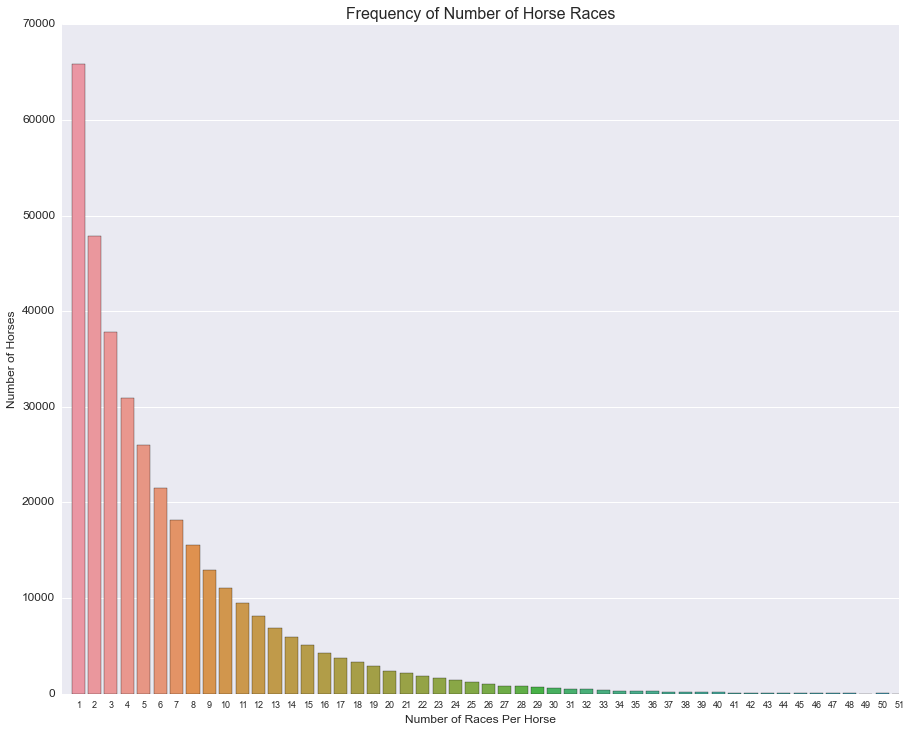

In [210]:
from collections import Counter
rc={'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12.0, 
    'axes.titlesize': 16, 'xtick.labelsize': 9, 'ytick.labelsize': 12}
sns.set(rc=rc)

x = Counter(traindf.name)
del x['NAN']
y = Counter(x.values())
y

print "Average number of races run:", average(x.values())

plt.figure(figsize=(15, 12)); 
ax = sns.barplot(y.keys(), y.values()); 
ax.set_xlabel("Number of Races Per Horse"); 
ax.set(xlim = (-1, 50), ylabel = "Number of Horses", title = "Frequency of Number of Horse Races"); 

In [211]:
x

Based on this plot, we can see a very interesting exponential distribution.  As expected, a large number of horses only placed in a small number of races, such as 1 or 2. 

We cut off this plot around 50, but some horses actually had raced in more than 100 races. The trend of the plot continued as expected up to this max value but we cut it off for the sake of clarity of viewing.  The most remarkable point we saw was that one horse, FREDDYSCOOTER, had placed in 113 races in our dataset.  We can only imagine how many races this horse had actually raced in considering we were only studying the top three finishers of any given race.  

From this, we were then curious how many races horses that were qualifying for Triple Crown races had won in the past.  We looked at a subset of the training data that was exclusively horses that raced in Triple Crown races and plotted a similar distribution below.  

Average number of races run: 9.55921052632


 (-1, 30),

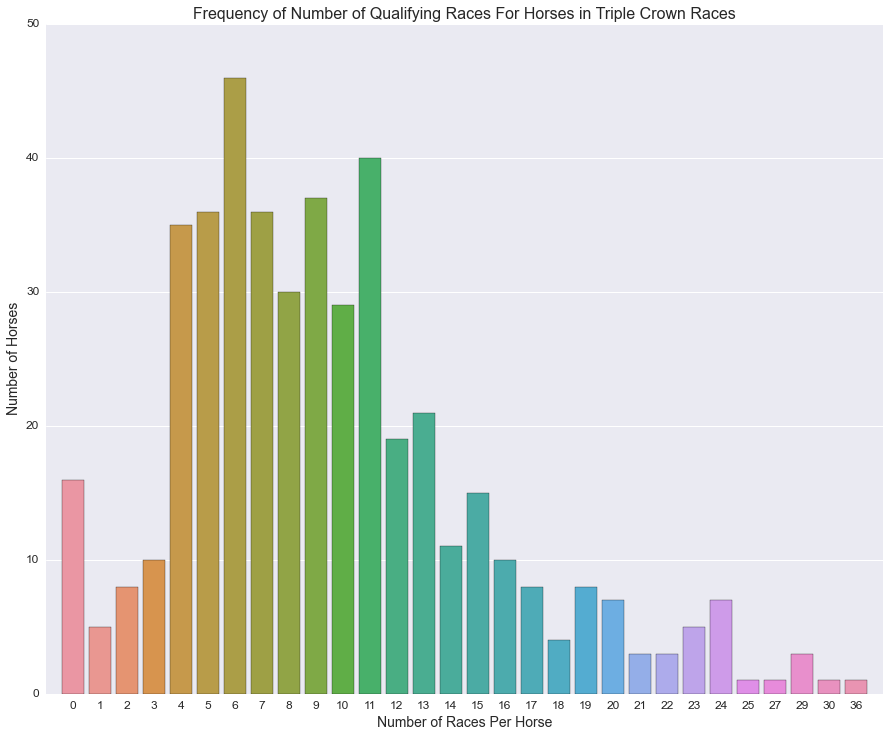

In [212]:
crown_horses = testdf.name.unique() 
z = [x[horse] for horse in crown_horses]

print "Average number of races run:", average(z)

rc={'font.size': 14, 'axes.labelsize': 14, 'legend.fontsize': 12.0, 
    'axes.titlesize': 16, 'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(rc=rc)

plt.figure(figsize=(15, 12)); 
ax = sns.barplot(Counter(z).keys(), Counter(z).values()); 
ax.set_xlabel("Number of Races Per Horse"); 
ax.set(xlim = (-1, 30), ylabel = "Number of Horses", title = "Frequency of Number of Qualifying Races For Horses in Triple Crown Races"); 

This plot is showing a different set of horses: rather than all horses, we are looking exclusively at the horses who have qualified for Triple Crown races, meaning they are likely the top tier of horses.  This distribution looks markedly different.  We are no longer see the exponential distribution that we saw before.  Instead, we see something that looks remotely normal, but not perfect by any means.  This indicates that the horses that qualify for the Triple Crown do not represent a random sample of the entire horse population, rather they tend to have raced in a similar number of races.  Furthermore, this plot indicates that horses must win in a certain number of races in order to qualify for the Triple Crown, an idea in line with the points process that is used to determine which horses qualify.  

The average number of races here is 9.6, compared to a population average of 6.6.  This makes a lot of sense, considering that horses must win quite a bit in order to qualify for the Triple Crown results.  It is important to note that we are only considering races where horses placed, rather than all races in which they participated, so that is another reason why this makes a lot of sense.  

We are still seeing this long upper tail that we saw before, but much less extremely so in this case.  We no longer excluded any data points from this graph, so the maximum number of races is 36, a much lower value than the 113 seen before.  This likely indicates that racing more does not always lead to qualifying for more elite races.  These horses that raced extremely large numbers of races were likely in lower skill level races, intending to win for money making purposes on numerous small bets, rather than horses whose energy should be conserved for the biggest races, *aka these are hard core hustlers.*  

We are surprised to see that a number of horses that have no prior information in horse racing history.  We suspect this is either due to missing data points or horses having qualified from the international sphere, since we did not include those races in our data set.  

Our next question was whether the distribution of number of horses placed in looked different for horses that won Triple Crown races.  

Average number of races run: 9.48571428571


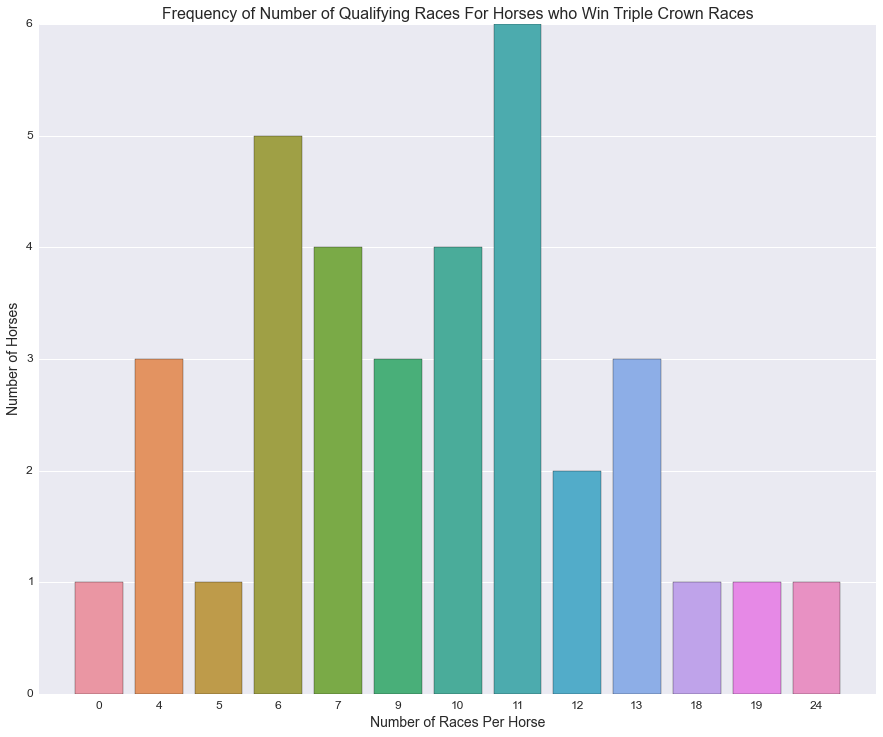

In [213]:
crown_horses = testdf[testdf.fin_pos == 1].name.unique() 
q = [x[horse] for horse in crown_horses]

print "Average number of races run:", average(q)

rc={'font.size': 14, 'axes.labelsize': 14, 'legend.fontsize': 12.0, 
    'axes.titlesize': 16, 'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(rc=rc)

plt.figure(figsize=(15, 12)); 
ax = sns.barplot(Counter(q).keys(), Counter(q).values()); 
ax.set_xlabel("Number of Races Per Horse"); 
ax.set(xlim = (-1, 13), ylabel = "Number of Horses", title = "Frequency of Number of Qualifying Races For Horses who Win Triple Crown Races"); 

This distribution is again a subset of the previous one.  We are now considering the races of exclusively horses that placed first at Triple Crown races.  These would be considered the most skilled horses of all considered.

We interestingly see a different trend again, indicating that racing patterns of champion horses are different than that of a normal horse. For example, no horses had placed in 1,2,or 3 races, while most were between 6 and 12.  This again fits the trend of the points system in that horses must win a certain number of times to accumulate enough points to qualify for the Triple Crown Races.  

Considering the average here, we see a value of 9.5, compared to a population average of 6.6 and a Triple Crown qualifier average of 9.6.  The fact that it is higher than the population average makes sense, since horses that win would be likely to make it to the highest level races.  Furthermore, the fact that this average is slightly less than the Triple Crown qualifier average could be due to the fact that horses worth the most may be raced the minimum number of times to qualify, so that there are in the best shape possible for the big races.  Trainers likely don't want to overwork or risk injuring their horses considering they are worth so much money.  

We do see one champion that has no historical information.  We expect this is likely from an early datepoint, an international horse, or just missing data.  Considering this is the only one, we are not too concerned, as most of the other horses have quite a bit of information about them.    

We were curious howmuch payouts varied over time and by location.  First, we just plotted the average win payoff for all tracks over time.  

Average payout over time: $ 4.12837281122


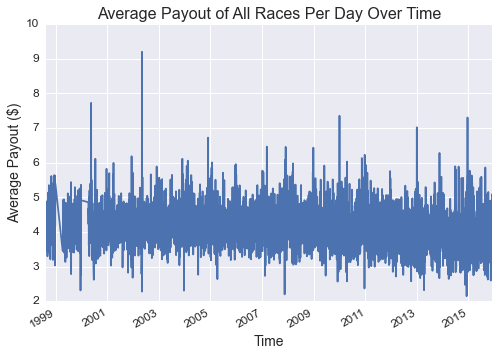

In [240]:
date_groups = traindf.groupby("date")
plt.plot(date_groups.win.mean().keys(), date_groups.win.mean()); 
plt.title("Average Payout of All Races Per Day Over Time")
print "Average payout over time: $", mean(date_groups.win.mean())
plt.gcf().autofmt_xdate()
plt.xlabel("Time")
plt.ylabel("Average Payout ($)"); 

This seems to be a fairly interesting time series here.  We are looking at average payout per day across the country.  There doesn't seem to be any strong trends here, other than that the average over time is around \$4.13, which has been fairly consistent.  

We then investigated a similar thing except grouping by track and looking over time again.  

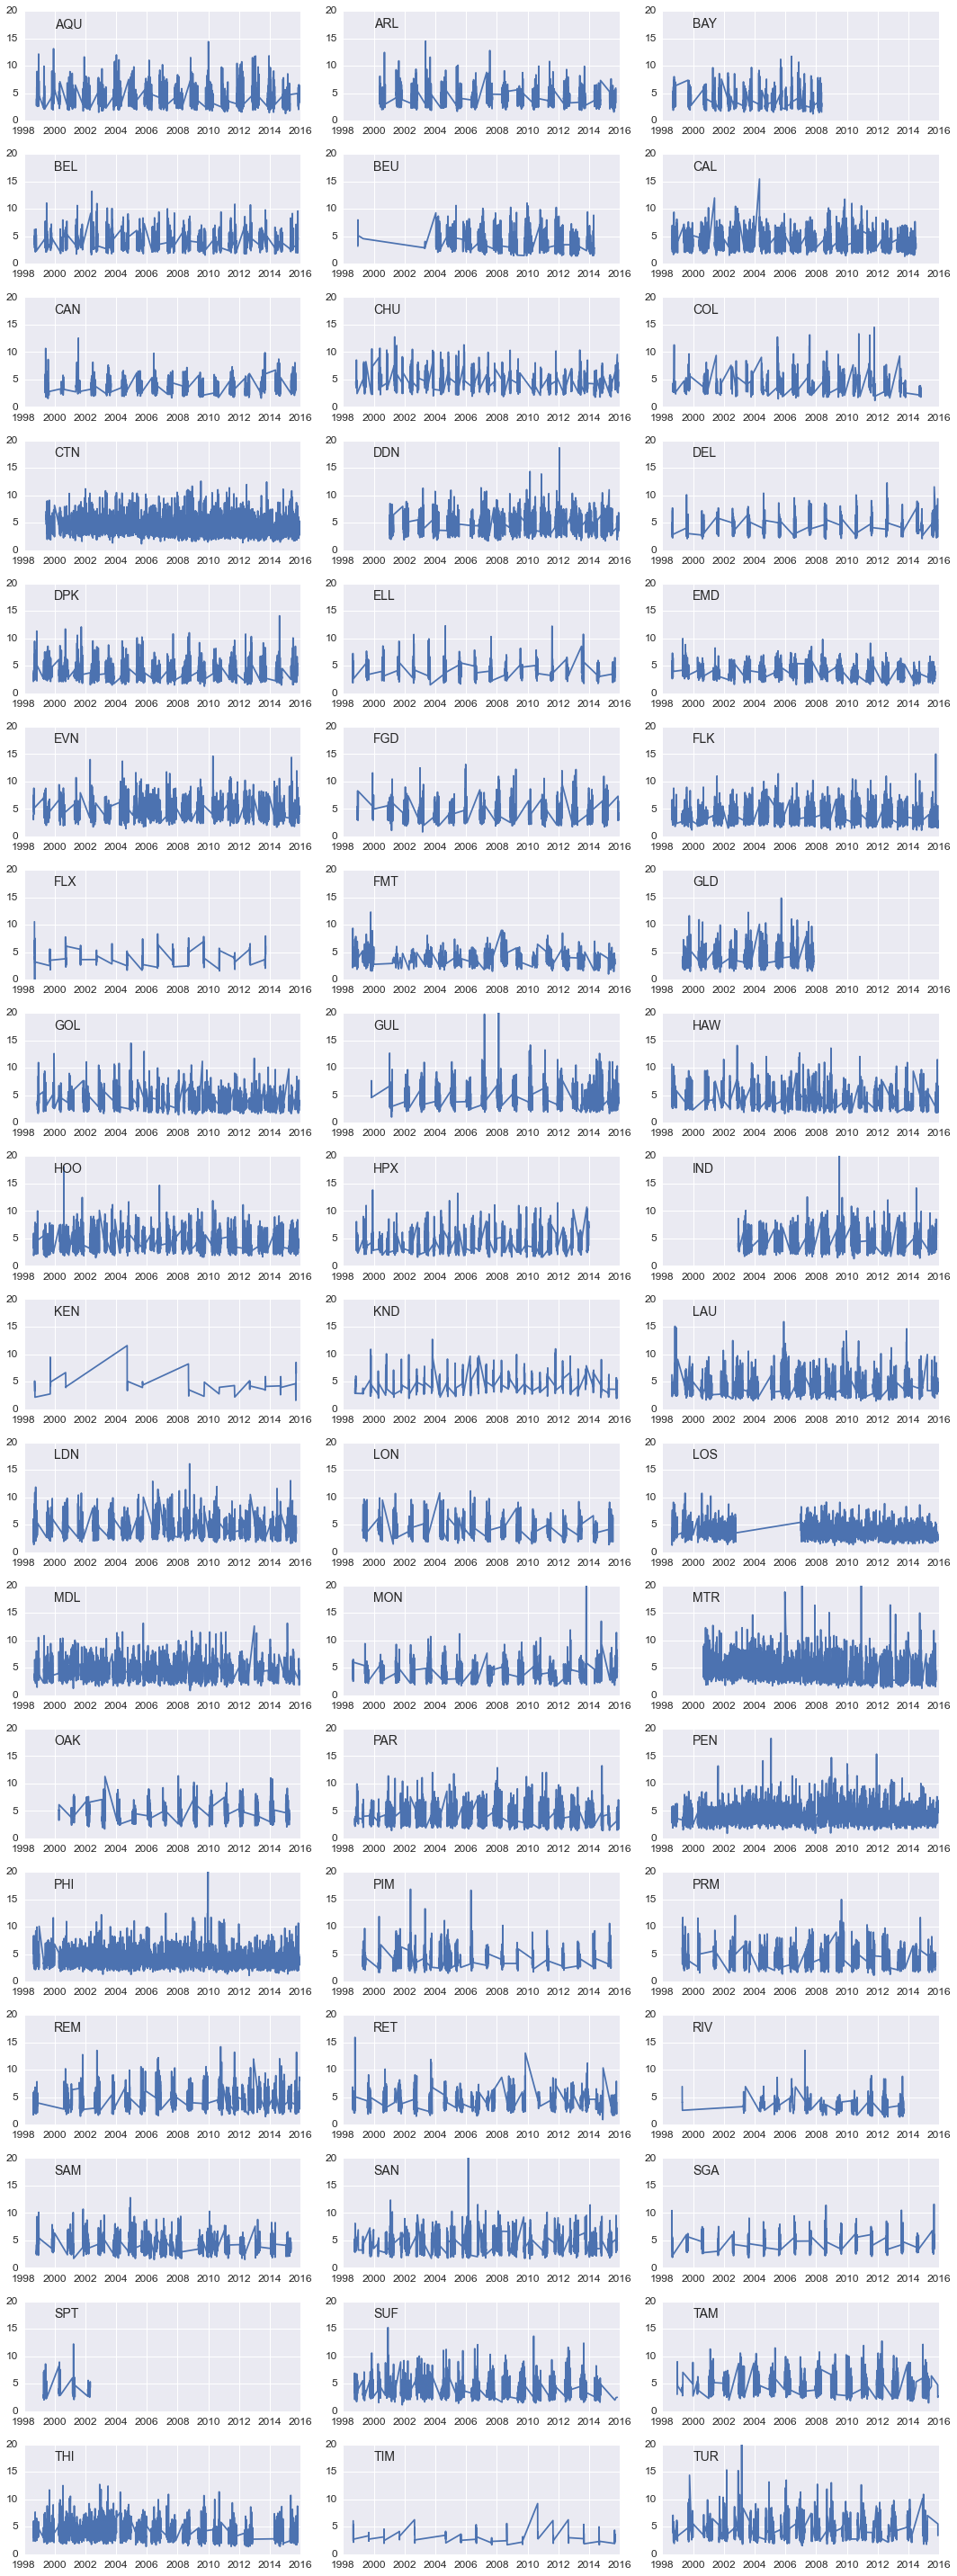

In [386]:
track_groups = traindf.groupby("track")
tracks = [x for x,y in track_groups]

#create a 18x3 grid of plots.
fig, axes = plt.subplots(nrows=18, ncols=3, figsize=(15,40), tight_layout=True)

ave_payout_track = {}
day_std_payout_track = {}
betw_day_std_payout_track = {} 

## plotting all the plots 
for ax, track in zip(axes.ravel(), tracks): 
    new_date_group = track_groups.get_group(track).groupby("date") 
    
    ave_payout_track[track] = mean(new_date_group.win.mean())
    day_std_payout_track[track] = mean(new_date_group.win.std())
    betw_day_std_payout_track[track] = std((new_date_group.win.mean()))
    
    ax.plot(new_date_group.win.mean().keys(), new_date_group.win.mean());
    ax.set_ylim(0, 20)
    ax.set_xlim(datetime.datetime(1998,1,1), datetime.datetime(2016,1,1))
    ax.annotate(track, xy = (datetime.datetime(2000,1,1),17), ha='left', fontsize=14)

These plots provide us with some interesting insights about each of the tracks.  Firstly, we notice that most tracks have seasonal trends to them.  This indicates one of two things.  Firstly, it could be that some tracks only race at certain times of year.  Therefore, the valley periods are just when betting isn't occuring at all.  Alterntively, it could be that there are certain seasons when betting is very popular or races are more exciting.  This would likely be that payouts are low during particular seasons, but much higher at other times.  For tracks where the Kentucky Derby, Belmont Stakes, and Preakness Stakes occur, this second theory is much more likely. 

To further investigate the differences in tracks, we calculated the average win payouts over time for each track as follows: 

In [372]:
print " Average Payout Across All Tracks: ", mean(ave_payout_track.values())
print " Average Daily Payout Per Track:"
ave_payout_track

 Average Payout Across All Tracks:  4.0996400306
 Average Daily Payout Per Track:


{'AQU': 4.04105139548169,
 'ARL': 4.1319662357497435,
 'BAY': 3.6464721179094517,
 'BEL': 4.104867735018318,
 'BEU': 3.92757619734463,
 'CAL': 3.8869810192721808,
 'CAN': 3.744831945944185,
 'CHU': 4.468622227212633,
 'COL': 4.061580498849967,
 'CTN': 4.278304328292956,
 'DDN': 4.584813934101494,
 'DEL': 4.424626856795387,
 'DPK': 3.741548657425401,
 'ELL': 4.069401383813144,
 'EMD': 3.7405311616028336,
 'EVN': 4.576768204918834,
 'FGD': 4.199146532519594,
 'FLK': 3.652525322376976,
 'FLX': 3.8641011439540875,
 'FMT': 3.666913017039378,
 'GLD': 3.9836936916560726,
 'GOL': 3.751444960057868,
 'GUL': 4.478310010993258,
 'HAW': 4.20626828384273,
 'HOO': 4.368899488375585,
 'HPX': 4.047754379264171,
 'IND': 4.332082586881848,
 'KEN': 4.507781339031339,
 'KND': 4.690967664498164,
 'LAU': 4.04266252756098,
 'LDN': 4.293639172613944,
 'LON': 4.099177803608127,
 'LOS': 3.6706041006548937,
 'MDL': 4.338707229841627,
 'MON': 3.931463346068106,
 'MTR': 4.373911137227302,
 'OAK': 4.438300655790953

In general, it looks like all the tracks have fairly consistent average payouts for wins, which are all pretty close to the overall average.  Furthermore, the range between max and min averages (below) is not very extreme.  This is quite interesting.  

In [293]:
print "Max Average Daily Payout: $", ave_payout_track[max(ave_payout_track)], "at", max(ave_payout_track)
print "Min Average Daily Payout: $", ave_payout_track[min(ave_payout_track)], "at", min(ave_payout_track)

Max Average Daily Payout: $ 4.50995550846 at TUR
Min Average Daily Payout: $ 4.04105139548 at AQU


To further understand these, we examined the standard deviations of each track both between days and within days.  We were curious if all races were actually just generally giving the same payouts or if there was more variability within tracks.  

In [392]:
print "Average Daily Standard Deviation Across All Tracks (Within days): ", mean(day_std_payout_track.values())
print "Max Average Standard Deviation (Within days):", day_std_payout_track[max(day_std_payout_track)], "at", max(day_std_payout_track)
print "Min Average Standard Deviation (Within days):", day_std_payout_track[min(day_std_payout_track)], "at", min(day_std_payout_track)
print "Average Daily Standard Deviation Per Tracks (Within days):"
day_std_payout_track

Average Daily Standard Deviation Across All Tracks (Within days):  9.48301448581
Max Average Standard Deviation (Within days): 15.2537427101 at WAR EMBLEM
Min Average Standard Deviation (Within days): 3.15217096906 at AFLEET ALEX
Average Daily Standard Deviation Per Tracks (Within days):


{'AFLEET ALEX': 3.1521709690595494,
 'AMERICAN PHAROAH': 2.5501416082684942,
 'ANIMAL KINGDOM': 14.253459619022713,
 'AQU': 8.545645520303339,
 'ARL': 8.490835189339991,
 'BARBARO': 5.6507226676476225,
 'BAY': 7.586277987168023,
 'BEL': 8.548089443077906,
 'BERNARDINI': 8.4069812259415304,
 'BEU': 8.353260238432831,
 'BIG BROWN': 9.4308006022818649,
 'CAL': 8.226742857853111,
 'CALIFORNIA CHROME': 3.9712603907209472,
 'CAN': 7.7064785805710425,
 'CHARISMATIC': 20.501284512602293,
 'CHU': 9.626473393914242,
 'COL': 8.733902134577496,
 'CTN': 9.161562670753726,
 'CURLIN': 3.6325804912817872,
 'DDN': 9.877957417130874,
 'DEL': 9.055661501091762,
 'DPK': 7.867424575082158,
 'DROSSELMEYER': 11.81240488177192,
 'ELL': 8.569270424391334,
 'EMD': 7.360343486205251,
 'EVN': 9.82429594187343,
 'FGD': 9.13063966836357,
 'FLK': 7.669605478060156,
 'FLX': 8.476387679058568,
 'FMT': 7.320107490125036,
 'FUNNY CIDE': 5.8992016163329222,
 'FUSAICHI PEGASUS': 1.4742229591663987,
 'GIACOMO': 32.00652711

In [393]:
print "Average Daily Standard Deviation Across All Tracks (Between days): ", mean(betw_day_std_payout_track.values())
print "Max Average Standard Deviation (Between days):", betw_day_std_payout_track[max(betw_day_std_payout_track)], "at", max(betw_day_std_payout_track)
print "Min Average Standard Deviation (Between days):", betw_day_std_payout_track[min(betw_day_std_payout_track)], "at", min(betw_day_std_payout_track)
print "Average Daily Standard Deviation Per Tracks (Between days):"
betw_day_std_payout_track

Average Daily Standard Deviation Across All Tracks (Between days):  0.973127896704
Max Average Standard Deviation (Between days): 0.0 at WAR EMBLEM
Min Average Standard Deviation (Between days): 0.0 at AFLEET ALEX
Average Daily Standard Deviation Per Tracks (Between days):


{'AFLEET ALEX': 0.0,
 'AMERICAN PHAROAH': 0.0,
 'ANIMAL KINGDOM': 0.0,
 'AQU': 1.6530233333858089,
 'ARL': 1.472754648243877,
 'BARBARO': 0.0,
 'BAY': 1.5340092916396526,
 'BEL': 1.4922295376388035,
 'BERNARDINI': 0.0,
 'BEU': 1.699508866705843,
 'BIG BROWN': 0.0,
 'CAL': 1.4220870320185153,
 'CALIFORNIA CHROME': 0.0,
 'CAN': 1.33582492702193,
 'CHARISMATIC': 0.0,
 'CHU': 1.6428644268357864,
 'COL': 1.6440158635387485,
 'CTN': 1.6148132802104094,
 'CURLIN': 0.0,
 'DDN': 1.6529372281928247,
 'DEL': 1.5701512621263005,
 'DPK': 1.470893080327794,
 'DROSSELMEYER': 0.0,
 'ELL': 1.5438404128495744,
 'EMD': 1.1853637231160448,
 'EVN': 1.7257571499021493,
 'FGD': 1.6550047758834552,
 'FLK': 1.4315949248167212,
 'FLX': 1.401620000303533,
 'FMT': 1.2707403928949705,
 'FUNNY CIDE': 0.0,
 'FUSAICHI PEGASUS': 0.0,
 'GIACOMO': 0.0,
 'GLD': 1.6260938430444467,
 'GOL': 1.546803902223991,
 'GUL': 1.8622362667679582,
 'HAW': 1.66073253700956,
 'HOO': 1.5760890983923317,
 'HPX': 1.6314050862835163,
 "I'L

Next, we performed a similar analysis for the champion horses.  

In [295]:
crown_horses

array(['CHARISMATIC', 'RED BULLET', 'POINT GIVEN', 'WAR EMBLEM',
       'FUNNY CIDE', 'SMARTY JONES', 'AFLEET ALEX', 'BERNARDINI', 'CURLIN',
       'BIG BROWN', 'RACHEL ALEXANDRA', 'LOOKIN AT LUCKY', 'SHACKLEFORD',
       "I'LL HAVE ANOTHER", 'OXBOW', 'CALIFORNIA CHROME',
       'AMERICAN PHAROAH', 'FUSAICHI PEGASUS', 'MONARCHOS', 'GIACOMO',
       'BARBARO', 'STREET SENSE', 'MINE THAT BIRD', 'SUPER SAVER',
       'ANIMAL KINGDOM', 'ORB', 'RAGS TO RICHES', "DA'TARA", 'SUMMER BIRD',
       'DROSSELMEYER', 'RULER ON ICE', 'UNION RAGS', 'PALACE MALICE',
       'TONALIST', 'JAZIL'], dtype=object)

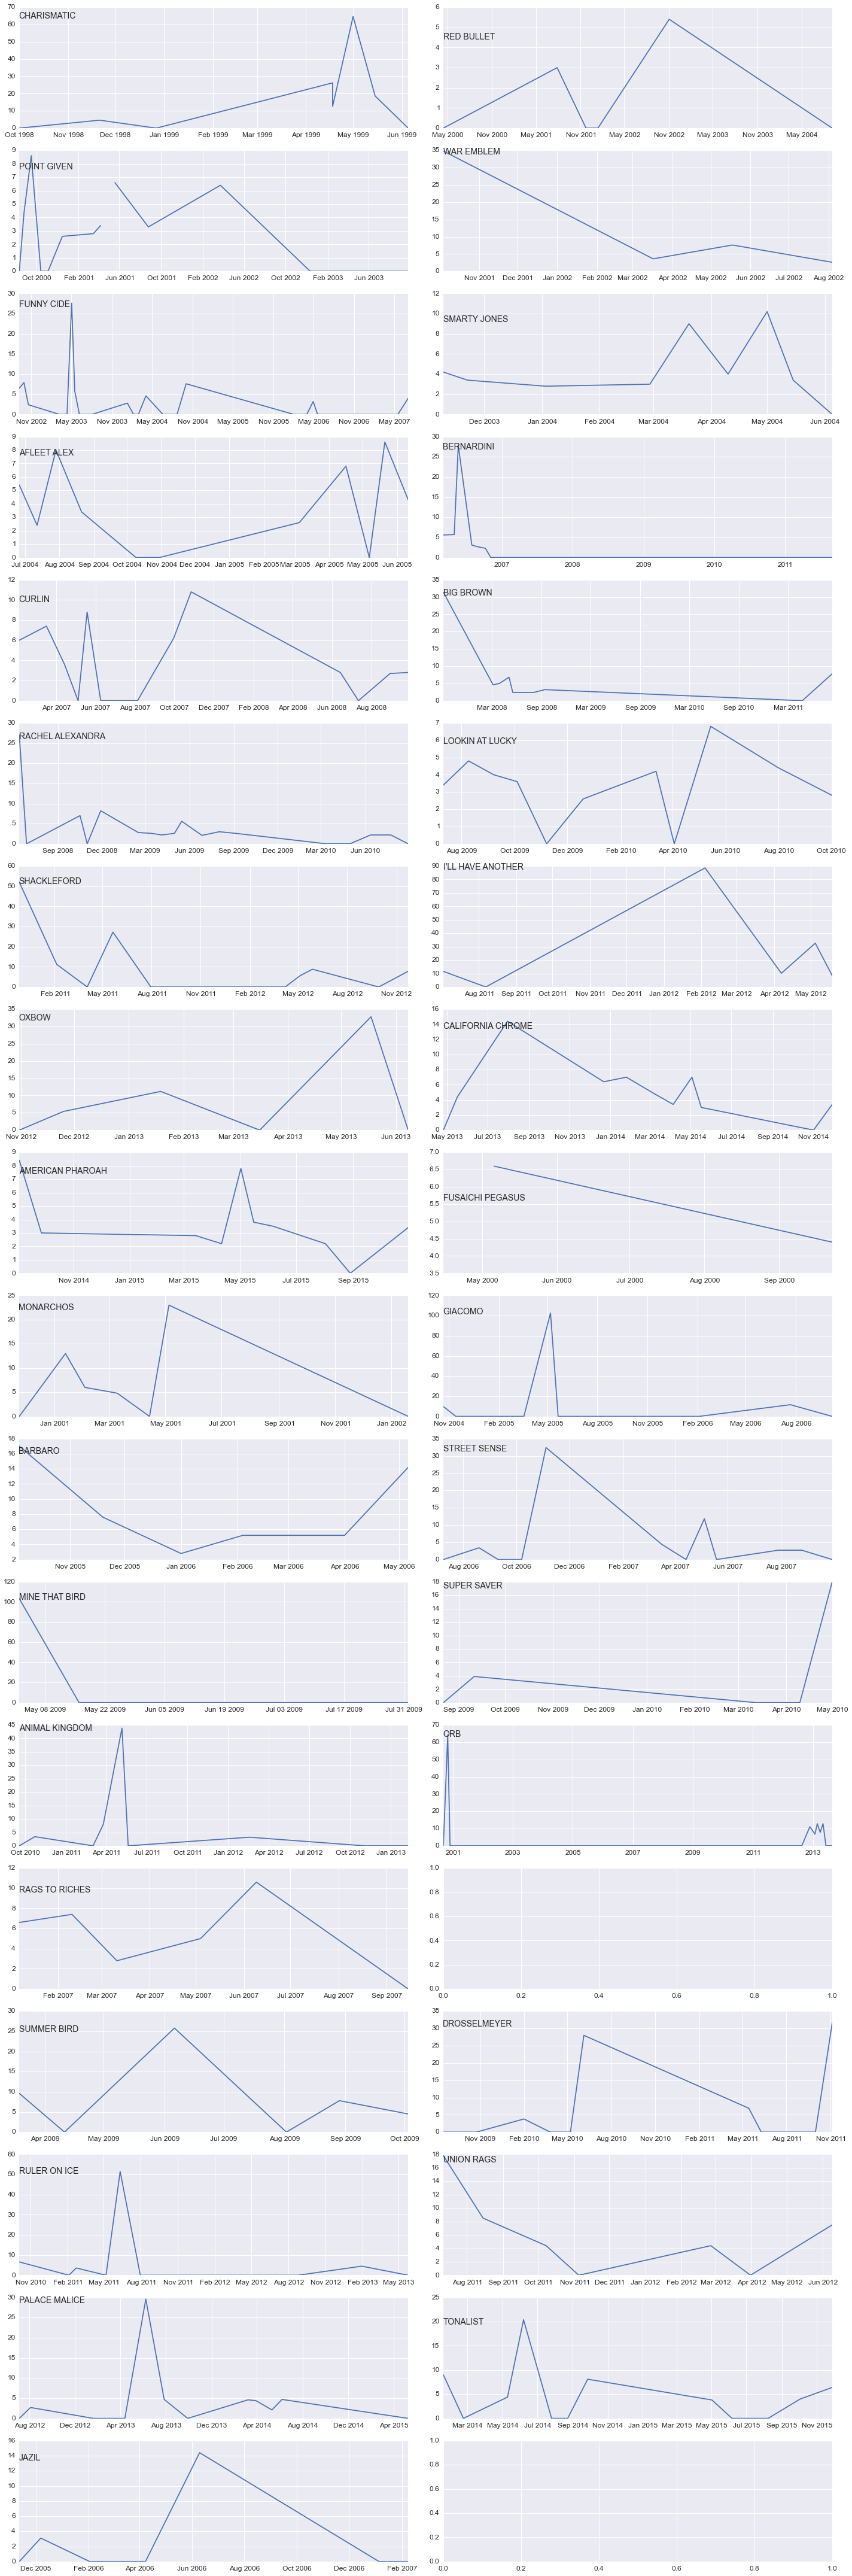

In [398]:
horse_groups = traindf.groupby("name")

#create a 18X2 grid of plots.
fig2, axes2 = plt.subplots(nrows=18, ncols=2, figsize=(20,60), tight_layout=True)
fig2.canvas.set_window_title("Payout Per Champion Horse Over Time")

ave_payout_horse = {}
day_std_payout_horse = {}
betw_day_std_payout_horse = {}

for ax, horse in zip(axes2.ravel(), crown_horses): 
    try: 
        new_date_group2 = horse_groups.get_group(horse).sort("date") 
    
        ave_payout_horse[horse] = mean(new_date_group2.win)
        day_std_payout_horse[horse] = mean(new_date_group2.win.std())
        betw_day_std_payout_horse[horse] = std((new_date_group2.win.mean()))

        ax.plot(new_date_group2.date, new_date_group2.win);
        ax.set_xlim(min(new_date_group2.date)-datetime.timedelta(0,6,0), max(new_date_group2.date)+ datetime.timedelta(0,6,0))
        ax.annotate(horse, xy = (min(new_date_group2.date), max(new_date_group2.win)-1), ha='left', fontsize=14)
    except: 
        pass


In [399]:
print " Average Payout Across All Horses: ", mean(ave_payout_horse.values())
print " Average Daily Payout Per Horse:"
ave_payout_horse

 Average Payout Across All Horses:  7.0912100318
 Average Daily Payout Per Horse:


{'AFLEET ALEX': 3.772727272727273,
 'AMERICAN PHAROAH': 3.71,
 'ANIMAL KINGDOM': 6.488888888888889,
 'BARBARO': 8.666666666666666,
 'BERNARDINI': 4.720000000000001,
 'BIG BROWN': 7.066666666666666,
 'CALIFORNIA CHROME': 4.890909090909091,
 'CHARISMATIC': 12.66,
 'CURLIN': 3.93076923076923,
 'DROSSELMEYER': 6.3909090909090915,
 'FUNNY CIDE': 3.016666666666667,
 'FUSAICHI PEGASUS': 4.933333333333333,
 'GIACOMO': 12.399999999999999,
 "I'LL HAVE ANOTHER": 25.233333333333334,
 'JAZIL': 2.5,
 'LOOKIN AT LUCKY': 3.3272727272727267,
 'MINE THAT BIRD': 25.8,
 'MONARCHOS': 6.685714285714285,
 'ORB': 10.49090909090909,
 'OXBOW': 8.233333333333333,
 'PALACE MALICE': 4.061538461538462,
 'POINT GIVEN': 2.1166666666666667,
 'RACHEL ALEXANDRA': 3.894444444444445,
 'RAGS TO RICHES': 5.3999999999999995,
 'RED BULLET': 1.2,
 'RULER ON ICE': 6.0181818181818185,
 'SHACKLEFORD': 9.383333333333333,
 'SMARTY JONES': 4.444444444444444,
 'STREET SENSE': 4.783333333333334,
 'SUMMER BIRD': 7.949999999999999,
 'SU

In [400]:
print "Max Average Daily Payout: $", ave_payout_horse[max(ave_payout_horse)], "at", max(ave_payout_horse)
print "Min Average Daily Payout: $", ave_payout_horse[min(ave_payout_horse)], "at", min(ave_payout_horse)

Max Average Daily Payout: $ 12.15 at WAR EMBLEM
Min Average Daily Payout: $ 3.77272727273 at AFLEET ALEX


In [401]:
print "Average Daily Standard Deviation Across All Horses (Within days): ", mean(day_std_payout_horse.values())
print "Max Average Standard Deviation (Within days):", day_std_payout_horse[max(day_std_payout_horse)], "at", max(day_std_payout_horse)
print "Min Average Standard Deviation (Within days):", day_std_payout_horse[min(day_std_payout_horse)], "at", min(day_std_payout_horse)
print "Average Daily Standard Deviation Per Horses (Within days):"
day_std_payout_horse

Average Daily Standard Deviation Across All Horses (Within days):  10.7501776277
Max Average Standard Deviation (Within days): 15.2537427101 at WAR EMBLEM
Min Average Standard Deviation (Within days): 3.15217096906 at AFLEET ALEX
Average Daily Standard Deviation Per Horses (Within days):


{'AFLEET ALEX': 3.1521709690595494,
 'AMERICAN PHAROAH': 2.5501416082684942,
 'ANIMAL KINGDOM': 14.253459619022713,
 'BARBARO': 5.6507226676476225,
 'BERNARDINI': 8.4069812259415304,
 'BIG BROWN': 9.4308006022818649,
 'CALIFORNIA CHROME': 3.9712603907209472,
 'CHARISMATIC': 20.501284512602293,
 'CURLIN': 3.6325804912817872,
 'DROSSELMEYER': 11.81240488177192,
 'FUNNY CIDE': 5.8992016163329222,
 'FUSAICHI PEGASUS': 1.4742229591663987,
 'GIACOMO': 32.006527112102894,
 "I'LL HAVE ANOTHER": 32.868079753260098,
 'JAZIL': 5.3730810528038759,
 'LOOKIN AT LUCKY': 1.9905230011687425,
 'MINE THAT BIRD': 51.600000000000009,
 'MONARCHOS': 8.6037644031413318,
 'ORB': 18.619208068307017,
 'OXBOW': 12.835211983705864,
 'PALACE MALICE': 7.9483267066658403,
 'POINT GIVEN': 2.8101182725789946,
 'RACHEL ALEXANDRA': 6.2291980620888934,
 'RAGS TO RICHES': 3.7029717795305976,
 'RED BULLET': 2.1633307652783937,
 'RULER ON ICE': 15.266356355189551,
 'SHACKLEFORD': 15.615716636152374,
 'SMARTY JONES': 3.179273

In [402]:
print "Average Daily Standard Deviation Across All Horses (Between days): ", mean(betw_day_std_payout_horse.values())
print "Max Average Standard Deviation (Between days):", betw_day_std_payout_horse[max(betw_day_std_payout_horse)], "at", max(betw_day_std_payout_horse)
print "Min Average Standard Deviation (Between days):", betw_day_std_payout_horse[min(betw_day_std_payout_horse)], "at", min(betw_day_std_payout_horse)
print "Average Daily Standard Deviation Per Horses (Between days):"
betw_day_std_payout_horse

Average Daily Standard Deviation Across All Horses (Between days):  0.0
Max Average Standard Deviation (Between days): 0.0 at WAR EMBLEM
Min Average Standard Deviation (Between days): 0.0 at AFLEET ALEX
Average Daily Standard Deviation Per Horses (Between days):


{'AFLEET ALEX': 0.0,
 'AMERICAN PHAROAH': 0.0,
 'ANIMAL KINGDOM': 0.0,
 'BARBARO': 0.0,
 'BERNARDINI': 0.0,
 'BIG BROWN': 0.0,
 'CALIFORNIA CHROME': 0.0,
 'CHARISMATIC': 0.0,
 'CURLIN': 0.0,
 'DROSSELMEYER': 0.0,
 'FUNNY CIDE': 0.0,
 'FUSAICHI PEGASUS': 0.0,
 'GIACOMO': 0.0,
 "I'LL HAVE ANOTHER": 0.0,
 'JAZIL': 0.0,
 'LOOKIN AT LUCKY': 0.0,
 'MINE THAT BIRD': 0.0,
 'MONARCHOS': 0.0,
 'ORB': 0.0,
 'OXBOW': 0.0,
 'PALACE MALICE': 0.0,
 'POINT GIVEN': 0.0,
 'RACHEL ALEXANDRA': 0.0,
 'RAGS TO RICHES': 0.0,
 'RED BULLET': 0.0,
 'RULER ON ICE': 0.0,
 'SHACKLEFORD': 0.0,
 'SMARTY JONES': 0.0,
 'STREET SENSE': 0.0,
 'SUMMER BIRD': 0.0,
 'SUPER SAVER': 0.0,
 'TONALIST': 0.0,
 'UNION RAGS': 0.0,
 'WAR EMBLEM': 0.0}

# Working on a Baseline

In [6]:
def find_races(horses_name, traindf=traindf):
    return traindf[traindf['name']==horses_name]

def find_avg_payouts(df, race_date=datetime.date.today()):
    out = {}
    df = df[df.date < race_date]
    out['win'] = np.mean(df.win[df.win != 0.0])
    out['place'] = np.mean(df.place[df.place != 0.0])
    out['show'] = np.mean(df.show[df.show != 0.0])
    return out

find_avg_payouts(find_races('SMARTY JONES', traindf=testdf), race_date=datetime.datetime(1998, 12, 12))

{'place': nan, 'show': nan, 'win': nan}

The payouts are already standardized to $2 bets, so we luckily don't have to deal with that problem

In [34]:
unique_test_dates = testdf['date'].unique()

def find_horses(date):
    return testdf['name'].loc[testdf['date'] == date]

def find_track(date):
    return testdf['track'].loc[testdf['date'] == date][0]

#find_horses(datetime.datetime(1998, 5, 15))
#type(testdf['date'][0])

We run a simple regression (aka Average) to get a dict where the keys are a tuple `(date, track, horse)` and the values are themselves dictionaries with keys `win`, `place`, `show` and values as the corresponding averages leading into raceday (excluding information we couldn't have on raceday). 

In [11]:
avg_payouts = {}
for i in testdf['date'].unique():
    race = testdf.loc[testdf.date == i]
    for j in range(len(race)):
        date = race.date.iloc[j]
        track = race.track.iloc[j]
        horse = race.name.iloc[j]
        avg_payouts[(date, track, horse)] = find_avg_payouts(
            find_races(race['name'].iloc[j], traindf=traindf), race_date=date)

In [ ]:
## this function takes a payout and returns the first odds digit, assuming a comparison to 1, i.e. x-1 
## of that horse to win when betting occured assuming original bet of $2 and assumed take by race track of 15% 
def payoff_to_odds(payoff, bet_amount=2.0, take = .15):
    return round(((payoff/(1-take) - bet_amount)/bet_amount),4)

def odds_to_percent(odds): 
    return (float(str(odds)[2]))/(float(str(odds)[0])+float((str(odds)[2])))

def normalize_odds(odds): 
    x = odds.split("-")
    if len(x) > 1: 
        return float(x[0])/float(x[1])
    else: 
        return float(x[0])
    
def make_favorite(string): 
    if "favorite" in string: 
        return True 
    else:
        return False 

In [33]:
def baseline(indict):
    profit = []
    cost = []
    count = []
    count2 = []
    for key in indict.keys():
        count2.append(1)
        date = key[0]
        track = key[1]
        horse = key[2]
        
        exp_win = indict[key]['win']
        exp_place = indict[key]['place']
        exp_show = indict[key]['show']
        
        # get the morning line odds for that day to compare
        odds = testdf.loc[(testdf.name == horse) & (testdf.track == track) & (testdf.date == date)]['Odds'].iloc[0]

        if odds > payoff_to_odds(exp_win):
            cost.append(2)
            
            if math.isnan(testdf.loc[(testdf.name == horse) & 
                                     (testdf.track == track) & 
                                     (testdf.date == date)]['win'].iloc[0]):
                count.append(1)
                pass
            
            else:
                profit.append(testdf.loc[(testdf.name == horse) & 
                                     (testdf.track == track) & 
                                     (testdf.date == date)]['win'].iloc[0])
        else:
            count.append(1)
            pass
        
    return ['baseline', no_bets_placed, race, year, profit_wins, profit_places, profit_shows, total_profit, cost]
            
baseline(avg_payouts)

(-320.20000000000005, 625.79999999999995, 946)

Dataframe of race, year, profit/loss on win baseline, profit/loss on place baseline, profit/loss on show baseline

In [46]:
def make_bets_baseline(indict, unique_test_dates=unique_test_dates): 
    outdict = {}
    outdict['method'] = []
    outdict['no_bets_placed'] = []
    outdict['race'] = []
    outdict['year'] = []
    outdict['profit_wins'] = []
    outdict['profit_places'] = []
    outdict['profit_shows'] = []
    outdict['total_profit'] = []
    outdict['cost'] = []
    for unique_date in unique_test_dates:
        newdict = {}
        for key in indict.keys():
            date = key[0]
            track = key[1]
            horse = key[2]
            
            
            if date == unique_date:
                newdict[key] = indict[key]
                  
        # now we have newdict, subsetting based on race (by unique date)
        
        spread_tup = []
        for key in newdict.keys():
            date = key[0]
            track = key[1]
            horse = key[2]

            exp_win = newdict[key]['win']
            exp_place = newdict[key]['place']
            exp_show = newdict[key]['show']

            # get the morning line odds for that day to compare
            odds = testdf.loc[(testdf.name == horse) & 
                              (testdf.track == track) & 
                              (testdf.date == date)]['Odds'].iloc[0]
            
            spread = odds - payoff_to_odds(exp_win)
            spread_tup.append((horse, spread))
            
        sorted_list = sorted(spread_tup,key=lambda x: x[1], reverse=True)
        
        print sorted_list[0:3]
            
#         outdict['method'] = []
#         outdict['no_bets_placed'] = []
#         outdict['race'] = []
#         outdict['year'] = []
#         outdict['profit_wins'] = []
#         outdict['profit_places'] = []
#         outdict['profit_shows'] = []
#         outdict['total_profit'] = []
#         outdict['cost'] = []

make_bets_baseline(avg_payouts)

[('HOT WELLS', nan), ('REAL QUIET', nan), ("CORONADO'S QUEST", nan)]
[('WORLDLY MANNER', nan), ('ADONIS', nan), ('BADGE', 55.0)]
[('HUGH HEFNER', 45.111800000000002), ('RED BULLET', nan), ("HAL'S HOPE", 18.805900000000001)]
[('BAY EAGLE', 87.182400000000001), ('GRIFFINITE', 51.217600000000004), ('PERCY HOPE', 48.600000000000001)]
[('MENACING DENNIS', 50.0824), ('MAGIC WEISNER', 40.135300000000001), ('EQUALITY', 24.441199999999998)]
[("FOUFA'S WARRIOR", 18.929399999999998), ('MIDWAY ROAD', 13.823499999999999), ('NEW YORK HERO', 11.188200000000002)]
[('SONG OF THE SWORD', 48.274500000000003), ('WATER CANNON', 36.4529), ('SIR SHACKLETON', 35.088200000000001)]
[('GALLOPING GROCER', 26.4314), ('GOING WILD', 22.911799999999999), ('SUN KING', 19.707800000000002)]
[("GREELEY'S GALAXY", 32.645099999999999), ("HEMINGWAY'S KEY", 25.694099999999999), ('DIABOLICAL', 25.147100000000002)]
[('MINT SLEWLEP', 39.100000000000001), ('C P WEST', 21.076499999999999), ('XCHANGER', 18.666699999999999)]
[('STE

## Final Analysis 
<i> What did you learn about the data? How did you answer the questions? How can you justify your answers? </i>